# Subgroup Classification of Medulloblastoma

### Introduction

This individual course work (ICW) focuses on classifying childhood medulloblastoma subgroups using high-dimensional epigenetic data from the Illumina 450K methylation microarray. Advanced machine learning methods will be applied to classify medulloblastoma cases into one of seven molecular subgroups ('WNT', 'SHH_Inf', 'SHH_Old', 'Grp3_LowRisk', 'Grp3_HighRisk', 'Grp4_LowRisk', 'Grp4_HighRisk'). The aim is to forecast patient outcomes with greater precision. The following steps will be taken to achieve this:

- 1.1 Dataset Preparation
- 1.2 Preprocessing and Visualization
- 2.0 Classification Model Development
- 3.0 Model Training and Evaluation

### Import necessary libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import NMF, PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
# adjust the display of rows and cols in a dataframe

#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')

### Mount Google Drive to Colab Environment

In [ ]:
# check whether the script is running on Google Colab or not
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    print("This script is running on Google Colab.")
else:
    print("This script is not running on Google Colab.")

This script is running on Google Colab.


In [ ]:
# mount Google Drive onto the Colab environment
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive/')
  print("Google Drive mounted successfully")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Google Drive mounted successfully


In [ ]:
# directory path where data files are stored
pth = '/content/drive/MyDrive/QUB MSc AI/ECS8055 - AI for Health/AI for Health - Final Assessment Project/data/'

## 1.1 Dataset Preparation

This phase of ICW involves the creation of a CSV file containing the top 10,000 variably methylated CpG sites.

- **Data Loading and Preprocessing:** Initially, both the data and labels files were loaded, and preprocessing steps were performed.
- **Variance Computation:** Next, the variances for all 450,000 methylated CpG sites were computed.
- **Top CpG Site Selection:** Subsequently, the top 10,000 methylated CpG sites with the highest variances were selected.
- **Dataset Storage:** Finally, the reduced dataset was stored in a dataframe named df_10K.

### 1.1.1 Preprocess data txt file

In [ ]:
# directory file names of 450K dataset & its labels
data_txt_file = 'GSE93646_processed_data.txt'
data_txt_path = os.path.join(pth, data_txt_file)

labels_csv_file = 'SubgroupAssignments_428MB.csv'
labels_csv_path = os.path.join(pth, labels_csv_file)

In [ ]:
# load data from a txt file
df_txt = pd.read_csv(data_txt_path, delimiter='\t')
df_txt

,Unnamed: 0,ID_REF,NMB109,Delection Pval,NMB110,Delection Pval.1,NMB111,Delection Pval.2,NMB113,Delection Pval.3,...,PNET350241,Delection Pval.423,PNET350292,Delection Pval.424,NMB906,Delection Pval.425,NMB915,Delection Pval.426,NMB916,Delection Pval.427
0,1,cg13869341,0.799830,0.0,0.909322,0.000000,0.902906,0.0,0.799254,0.0,...,0.787750,0.000000e+00,0.822955,0.0,0.878921,0.000000e+00,0.952915,0.000000e+00,0.935460,0.000000e+00
1,2,cg14008030,0.649776,0.0,0.596558,0.000000,0.552741,0.0,0.614949,0.0,...,0.691159,0.000000e+00,0.819043,0.0,0.751000,0.000000e+00,0.835032,0.000000e+00,0.899616,0.000000e+00
2,3,cg12045430,0.031531,0.0,0.032125,0.000000,0.045062,0.0,0.046144,0.0,...,0.191291,0.000000e+00,0.138586,0.0,0.044348,0.000000e+00,0.043077,0.000000e+00,0.060116,0.000000e+00
3,4,cg20826792,0.076299,0.0,0.094180,0.000000,0.195500,0.0,0.078382,0.0,...,0.172784,0.000000e+00,0.201939,0.0,0.089116,0.000000e+00,0.128718,0.000000e+00,0.126576,0.000000e+00
4,5,cg00381604,0.023703,0.0,0.021747,0.000000,0.040555,0.0,0.032150,0.0,...,0.234532,0.000000e+00,0.035959,0.0,0.041841,0.000000e+00,0.040751,0.000000e+00,0.043732,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485507,485508,cg17939569,0.351777,0.0,0.245702,0.996892,0.885274,0.0,0.515132,0.0,...,0.704583,0.000000e+00,0.512227,0.0,0.651841,0.000000e+00,0.278699,2.156685e-01,0.246828,7.679368e-01
485508,485509,cg13365400,0.852231,0.0,0.261512,0.737713,0.815788,0.0,0.092990,0.0,...,0.671615,0.000000e+00,0.329124,0.0,0.175082,5.616618e-13,0.252840,9.938565e-01,0.240301,4.411481e-01
485509,485510,cg21106100,0.901513,0.0,0.283994,0.505077,0.873270,0.0,0.903837,0.0,...,0.196779,7.002996e-05,0.594548,0.0,0.485580,0.000000e+00,0.264184,6.909173e-11,0.282352,3.023976e-09
485510,485511,cg08265308,0.940009,0.0,0.367879,0.773847,0.942038,0.0,0.903888,0.0,...,0.643717,2.201329e-10,0.667016,0.0,0.462351,5.042540e-04,0.332762,6.968805e-09,0.310866,1.227845e-02


In [ ]:
# drop a 'Unnamed: 0' index column
df_txt.drop('Unnamed: 0', axis=1, inplace=True)
df_txt

,ID_REF,NMB109,Delection Pval,NMB110,Delection Pval.1,NMB111,Delection Pval.2,NMB113,Delection Pval.3,NMB115,...,PNET350241,Delection Pval.423,PNET350292,Delection Pval.424,NMB906,Delection Pval.425,NMB915,Delection Pval.426,NMB916,Delection Pval.427
0,cg13869341,0.799830,0.0,0.909322,0.000000,0.902906,0.0,0.799254,0.0,0.884145,...,0.787750,0.000000e+00,0.822955,0.0,0.878921,0.000000e+00,0.952915,0.000000e+00,0.935460,0.000000e+00
1,cg14008030,0.649776,0.0,0.596558,0.000000,0.552741,0.0,0.614949,0.0,0.757593,...,0.691159,0.000000e+00,0.819043,0.0,0.751000,0.000000e+00,0.835032,0.000000e+00,0.899616,0.000000e+00
2,cg12045430,0.031531,0.0,0.032125,0.000000,0.045062,0.0,0.046144,0.0,0.081508,...,0.191291,0.000000e+00,0.138586,0.0,0.044348,0.000000e+00,0.043077,0.000000e+00,0.060116,0.000000e+00
3,cg20826792,0.076299,0.0,0.094180,0.000000,0.195500,0.0,0.078382,0.0,0.079897,...,0.172784,0.000000e+00,0.201939,0.0,0.089116,0.000000e+00,0.128718,0.000000e+00,0.126576,0.000000e+00
4,cg00381604,0.023703,0.0,0.021747,0.000000,0.040555,0.0,0.032150,0.0,0.028610,...,0.234532,0.000000e+00,0.035959,0.0,0.041841,0.000000e+00,0.040751,0.000000e+00,0.043732,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485507,cg17939569,0.351777,0.0,0.245702,0.996892,0.885274,0.0,0.515132,0.0,0.275389,...,0.704583,0.000000e+00,0.512227,0.0,0.651841,0.000000e+00,0.278699,2.156685e-01,0.246828,7.679368e-01
485508,cg13365400,0.852231,0.0,0.261512,0.737713,0.815788,0.0,0.092990,0.0,0.282354,...,0.671615,0.000000e+00,0.329124,0.0,0.175082,5.616618e-13,0.252840,9.938565e-01,0.240301,4.411481e-01
485509,cg21106100,0.901513,0.0,0.283994,0.505077,0.873270,0.0,0.903837,0.0,0.874868,...,0.196779,7.002996e-05,0.594548,0.0,0.485580,0.000000e+00,0.264184,6.909173e-11,0.282352,3.023976e-09
485510,cg08265308,0.940009,0.0,0.367879,0.773847,0.942038,0.0,0.903888,0.0,0.942513,...,0.643717,2.201329e-10,0.667016,0.0,0.462351,5.042540e-04,0.332762,6.968805e-09,0.310866,1.227845e-02


In [ ]:
# drop delection pval columns using using regular expressions
delection_pval_cols = [col for col in df_txt.columns if re.match(r'^Delection Pval|^Delection Pval.\d+$', col)]
print("Head: ", delection_pval_cols[:5])
print("Tail: ", delection_pval_cols[-5:])

Head:  ['Delection Pval', 'Delection Pval.1', 'Delection Pval.2', 'Delection Pval.3', 'Delection Pval.4']
Tail:  ['Delection Pval.423', 'Delection Pval.424', 'Delection Pval.425', 'Delection Pval.426', 'Delection Pval.427']


In [ ]:
# drop delection pval columns using using regular expressions
df_txt = df_txt.drop(columns=delection_pval_cols, axis=1)
df_txt

,ID_REF,NMB109,NMB110,NMB111,NMB113,NMB115,NMB116,NMB118,NMB119,NMB123,...,PNET350120,PNET350124,PNET350161,PNET350198,PNET350217,PNET350241,PNET350292,NMB906,NMB915,NMB916
0,cg13869341,0.799830,0.909322,0.902906,0.799254,0.884145,0.777477,0.924769,0.930983,0.913496,...,0.790207,0.810780,0.801555,0.855695,0.859737,0.787750,0.822955,0.878921,0.952915,0.935460
1,cg14008030,0.649776,0.596558,0.552741,0.614949,0.757593,0.791730,0.565691,0.714695,0.608594,...,0.684024,0.624377,0.671782,0.737800,0.695939,0.691159,0.819043,0.751000,0.835032,0.899616
2,cg12045430,0.031531,0.032125,0.045062,0.046144,0.081508,0.074025,0.090842,0.062277,0.041843,...,0.390616,0.098999,0.224150,0.167838,0.254427,0.191291,0.138586,0.044348,0.043077,0.060116
3,cg20826792,0.076299,0.094180,0.195500,0.078382,0.079897,0.075308,0.094380,0.066652,0.089482,...,0.390616,0.095051,0.158360,0.166101,0.232053,0.172784,0.201939,0.089116,0.128718,0.126576
4,cg00381604,0.023703,0.021747,0.040555,0.032150,0.028610,0.030223,0.031613,0.032370,0.034684,...,0.215108,0.041756,0.059094,0.050280,0.244330,0.234532,0.035959,0.041841,0.040751,0.043732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485507,cg17939569,0.351777,0.245702,0.885274,0.515132,0.275389,0.440279,0.267198,0.666005,0.347896,...,0.418414,0.779066,0.274687,0.768861,0.519383,0.704583,0.512227,0.651841,0.278699,0.246828
485508,cg13365400,0.852231,0.261512,0.815788,0.092990,0.282354,0.304474,0.274370,0.629400,0.781893,...,0.151018,0.216797,0.140549,0.819341,0.722834,0.671615,0.329124,0.175082,0.252840,0.240301
485509,cg21106100,0.901513,0.283994,0.873270,0.903837,0.874868,0.338423,0.290039,0.830484,0.878046,...,0.761797,0.928159,0.681354,0.748931,0.190511,0.196779,0.594548,0.485580,0.264184,0.282352
485510,cg08265308,0.940009,0.367879,0.942038,0.903888,0.942513,0.875263,0.301601,0.917240,0.943138,...,0.695293,0.947935,0.777044,0.769986,0.620949,0.643717,0.667016,0.462351,0.332762,0.310866


In [ ]:
# set patient ID as an index column
df_txt.set_index('ID_REF', inplace=True)
df_txt

,NMB109,NMB110,NMB111,NMB113,NMB115,NMB116,NMB118,NMB119,NMB123,NMB125,...,PNET350120,PNET350124,PNET350161,PNET350198,PNET350217,PNET350241,PNET350292,NMB906,NMB915,NMB916
ID_REF,,,,,,,,,,,,,,,,,,,,,
cg13869341,0.799830,0.909322,0.902906,0.799254,0.884145,0.777477,0.924769,0.930983,0.913496,0.812275,...,0.790207,0.810780,0.801555,0.855695,0.859737,0.787750,0.822955,0.878921,0.952915,0.935460
cg14008030,0.649776,0.596558,0.552741,0.614949,0.757593,0.791730,0.565691,0.714695,0.608594,0.606265,...,0.684024,0.624377,0.671782,0.737800,0.695939,0.691159,0.819043,0.751000,0.835032,0.899616
cg12045430,0.031531,0.032125,0.045062,0.046144,0.081508,0.074025,0.090842,0.062277,0.041843,0.034229,...,0.390616,0.098999,0.224150,0.167838,0.254427,0.191291,0.138586,0.044348,0.043077,0.060116
cg20826792,0.076299,0.094180,0.195500,0.078382,0.079897,0.075308,0.094380,0.066652,0.089482,0.068100,...,0.390616,0.095051,0.158360,0.166101,0.232053,0.172784,0.201939,0.089116,0.128718,0.126576
cg00381604,0.023703,0.021747,0.040555,0.032150,0.028610,0.030223,0.031613,0.032370,0.034684,0.028652,...,0.215108,0.041756,0.059094,0.050280,0.244330,0.234532,0.035959,0.041841,0.040751,0.043732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cg17939569,0.351777,0.245702,0.885274,0.515132,0.275389,0.440279,0.267198,0.666005,0.347896,0.242391,...,0.418414,0.779066,0.274687,0.768861,0.519383,0.704583,0.512227,0.651841,0.278699,0.246828
cg13365400,0.852231,0.261512,0.815788,0.092990,0.282354,0.304474,0.274370,0.629400,0.781893,0.264176,...,0.151018,0.216797,0.140549,0.819341,0.722834,0.671615,0.329124,0.175082,0.252840,0.240301
cg21106100,0.901513,0.283994,0.873270,0.903837,0.874868,0.338423,0.290039,0.830484,0.878046,0.251424,...,0.761797,0.928159,0.681354,0.748931,0.190511,0.196779,0.594548,0.485580,0.264184,0.282352


In [ ]:
# set patient ID as an index column
df_txt_transposed = df_txt.transpose()
df_txt_transposed

ID_REF,cg13869341,cg14008030,cg12045430,cg20826792,cg00381604,cg20253340,cg21870274,cg03130891,cg24335620,cg16162899,...,cg26983430,cg22051787,cg01757887,cg00061679,cg03930849,cg17939569,cg13365400,cg21106100,cg08265308,cg14273923
NMB109,0.799830,0.649776,0.031531,0.076299,0.023703,0.589630,0.844501,0.186703,0.645334,0.671212,...,0.610398,0.723914,0.921794,0.108792,0.481631,0.351777,0.852231,0.901513,0.940009,0.815921
NMB110,0.909322,0.596558,0.032125,0.094180,0.021747,0.607228,0.873312,0.070818,0.669788,0.628464,...,0.342791,0.411211,0.260633,0.284669,0.283791,0.245702,0.261512,0.283994,0.367879,0.323668
NMB111,0.902906,0.552741,0.045062,0.195500,0.040555,0.503568,0.861327,0.212787,0.834279,0.883841,...,0.722548,0.830144,0.860312,0.692982,0.252820,0.885274,0.815788,0.873270,0.942038,0.868381
NMB113,0.799254,0.614949,0.046144,0.078382,0.032150,0.483676,0.613374,0.089755,0.711666,0.653682,...,0.766053,0.730141,0.120859,0.193487,0.136703,0.515132,0.092990,0.903837,0.903888,0.900505
NMB115,0.884145,0.757593,0.081508,0.079897,0.028610,0.614838,0.820062,0.215283,0.835262,0.581383,...,0.819806,0.779651,0.398389,0.156035,0.126535,0.275389,0.282354,0.874868,0.942513,0.844987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PNET350241,0.787750,0.691159,0.191291,0.172784,0.234532,0.644338,0.869882,0.114600,0.856295,0.806495,...,0.560254,0.797970,0.754604,0.366125,0.609234,0.704583,0.671615,0.196779,0.643717,0.181048
PNET350292,0.822955,0.819043,0.138586,0.201939,0.035959,0.636924,0.812017,0.224928,0.804168,0.614923,...,0.735921,0.635807,0.497290,0.126190,0.069477,0.512227,0.329124,0.594548,0.667016,0.866905
NMB906,0.878921,0.751000,0.044348,0.089116,0.041841,0.389642,0.446799,0.194280,0.883857,0.453996,...,0.637136,0.893816,0.646608,0.520225,0.375821,0.651841,0.175082,0.485580,0.462351,0.846309
NMB915,0.952915,0.835032,0.043077,0.128718,0.040751,0.661553,0.883923,0.196994,0.853677,0.731638,...,0.319457,0.513781,0.287173,0.272421,0.272464,0.278699,0.252840,0.264184,0.332762,0.272163


In [ ]:
# check info of a df
df_txt_transposed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 428 entries, NMB109 to NMB916
Columns: 485512 entries, cg13869341 to cg14273923
dtypes: float64(485512)
memory usage: 1.5+ GB


### 1.1.2 Preprocess labels csv file

In [ ]:
# load labels data file into a df
df_labels = pd.read_csv(labels_csv_path)
df_labels

,SampleID,Named_4_grp,Named_7_grp,Sentrix_ID,Sentrix_Position
0,NMB109,Grp4,Grp4_HighRisk,7973201043,R02C01
1,NMB110,Grp4,Grp4_LowRisk,7973201043,R05C02
2,NMB111,Grp4,Grp4_LowRisk,9422491032,R02C02
3,NMB113,SHH,SHH_Inf,7973201126,R01C02
4,NMB115,WNT,WNT,9421912022,R05C02
...,...,...,...,...,...
423,PNET350161,Grp4,Grp4_HighRisk,9647455143,R02C01
424,PNET350198,Grp4,Grp4_HighRisk,9761749106,R01C01
425,PNET350217,Grp4,Grp4_HighRisk,9647455144,R05C01
426,PNET350241,Grp4,Grp4_LowRisk,9647455134,R02C02


In [ ]:
# set patient ID as an index column
df_labels.set_index('SampleID', inplace=True)
df_labels

,Named_4_grp,Named_7_grp,Sentrix_ID,Sentrix_Position
SampleID,,,,
NMB109,Grp4,Grp4_HighRisk,7973201043,R02C01
NMB110,Grp4,Grp4_LowRisk,7973201043,R05C02
NMB111,Grp4,Grp4_LowRisk,9422491032,R02C02
NMB113,SHH,SHH_Inf,7973201126,R01C02
NMB115,WNT,WNT,9421912022,R05C02
...,...,...,...,...
PNET350161,Grp4,Grp4_HighRisk,9647455143,R02C01
PNET350198,Grp4,Grp4_HighRisk,9761749106,R01C01
PNET350217,Grp4,Grp4_HighRisk,9647455144,R05C01


In [ ]:
# check info of a df
df_labels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 428 entries, NMB109 to PNET350292
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Named_4_grp       428 non-null    object
 1   Named_7_grp       428 non-null    object
 2   Sentrix_ID        428 non-null    int64 
 3   Sentrix_Position  428 non-null    object
dtypes: int64(1), object(3)
memory usage: 16.7+ KB


### 1.1.3 Concatenate data and labels

**Note:**
Before concatenating the dataframes, the index of the data dataframe required to be reordered. This is because the patient IDs in the data dataframe do not match with those in the labels dataframe.

In [ ]:
# get index column from txt df
txt_index_column = df_txt_transposed.index
txt_index_list = txt_index_column.tolist()
#print(txt_index_list)

In [ ]:
# get index column from labels df
labels_index_column = df_labels.index
labels_index_list = labels_index_column.tolist()
#print(labels_index_list)

In [ ]:
# reorder index column of txt df
df_txt_reordered = df_txt_transposed.reindex(index=labels_index_list)
df_txt_reordered

ID_REF,cg13869341,cg14008030,cg12045430,cg20826792,cg00381604,cg20253340,cg21870274,cg03130891,cg24335620,cg16162899,...,cg26983430,cg22051787,cg01757887,cg00061679,cg03930849,cg17939569,cg13365400,cg21106100,cg08265308,cg14273923
NMB109,0.799830,0.649776,0.031531,0.076299,0.023703,0.589630,0.844501,0.186703,0.645334,0.671212,...,0.610398,0.723914,0.921794,0.108792,0.481631,0.351777,0.852231,0.901513,0.940009,0.815921
NMB110,0.909322,0.596558,0.032125,0.094180,0.021747,0.607228,0.873312,0.070818,0.669788,0.628464,...,0.342791,0.411211,0.260633,0.284669,0.283791,0.245702,0.261512,0.283994,0.367879,0.323668
NMB111,0.902906,0.552741,0.045062,0.195500,0.040555,0.503568,0.861327,0.212787,0.834279,0.883841,...,0.722548,0.830144,0.860312,0.692982,0.252820,0.885274,0.815788,0.873270,0.942038,0.868381
NMB113,0.799254,0.614949,0.046144,0.078382,0.032150,0.483676,0.613374,0.089755,0.711666,0.653682,...,0.766053,0.730141,0.120859,0.193487,0.136703,0.515132,0.092990,0.903837,0.903888,0.900505
NMB115,0.884145,0.757593,0.081508,0.079897,0.028610,0.614838,0.820062,0.215283,0.835262,0.581383,...,0.819806,0.779651,0.398389,0.156035,0.126535,0.275389,0.282354,0.874868,0.942513,0.844987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PNET350161,0.801555,0.671782,0.224150,0.158360,0.059094,0.573236,0.574425,0.233413,0.787507,0.816076,...,0.611195,0.189824,0.743141,0.313089,0.523199,0.274687,0.140549,0.681354,0.777044,0.076449
PNET350198,0.855695,0.737800,0.167838,0.166101,0.050280,0.526327,0.793390,0.217237,0.779145,0.498706,...,0.808657,0.754604,0.837359,0.318157,0.237746,0.768861,0.819341,0.748931,0.769986,0.411181
PNET350217,0.859737,0.695939,0.254427,0.232053,0.244330,0.579144,0.675315,0.144559,0.822913,0.750949,...,0.713842,0.816757,0.828730,0.285410,0.173921,0.519383,0.722834,0.190511,0.620949,0.861880
PNET350241,0.787750,0.691159,0.191291,0.172784,0.234532,0.644338,0.869882,0.114600,0.856295,0.806495,...,0.560254,0.797970,0.754604,0.366125,0.609234,0.704583,0.671615,0.196779,0.643717,0.181048


In [ ]:
# check the ordered index column
txt_index_column = df_txt_reordered.index
txt_index_list = txt_index_column.tolist()
#print(txt_index_list)

In [ ]:
# concatenate the two data and labels dfs
df_concatenated = pd.concat([df_txt_reordered, df_labels], axis=1)
df_concatenated

,cg13869341,cg14008030,cg12045430,cg20826792,cg00381604,cg20253340,cg21870274,cg03130891,cg24335620,cg16162899,...,cg03930849,cg17939569,cg13365400,cg21106100,cg08265308,cg14273923,Named_4_grp,Named_7_grp,Sentrix_ID,Sentrix_Position
NMB109,0.799830,0.649776,0.031531,0.076299,0.023703,0.589630,0.844501,0.186703,0.645334,0.671212,...,0.481631,0.351777,0.852231,0.901513,0.940009,0.815921,Grp4,Grp4_HighRisk,7973201043,R02C01
NMB110,0.909322,0.596558,0.032125,0.094180,0.021747,0.607228,0.873312,0.070818,0.669788,0.628464,...,0.283791,0.245702,0.261512,0.283994,0.367879,0.323668,Grp4,Grp4_LowRisk,7973201043,R05C02
NMB111,0.902906,0.552741,0.045062,0.195500,0.040555,0.503568,0.861327,0.212787,0.834279,0.883841,...,0.252820,0.885274,0.815788,0.873270,0.942038,0.868381,Grp4,Grp4_LowRisk,9422491032,R02C02
NMB113,0.799254,0.614949,0.046144,0.078382,0.032150,0.483676,0.613374,0.089755,0.711666,0.653682,...,0.136703,0.515132,0.092990,0.903837,0.903888,0.900505,SHH,SHH_Inf,7973201126,R01C02
NMB115,0.884145,0.757593,0.081508,0.079897,0.028610,0.614838,0.820062,0.215283,0.835262,0.581383,...,0.126535,0.275389,0.282354,0.874868,0.942513,0.844987,WNT,WNT,9421912022,R05C02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PNET350161,0.801555,0.671782,0.224150,0.158360,0.059094,0.573236,0.574425,0.233413,0.787507,0.816076,...,0.523199,0.274687,0.140549,0.681354,0.777044,0.076449,Grp4,Grp4_HighRisk,9647455143,R02C01
PNET350198,0.855695,0.737800,0.167838,0.166101,0.050280,0.526327,0.793390,0.217237,0.779145,0.498706,...,0.237746,0.768861,0.819341,0.748931,0.769986,0.411181,Grp4,Grp4_HighRisk,9761749106,R01C01
PNET350217,0.859737,0.695939,0.254427,0.232053,0.244330,0.579144,0.675315,0.144559,0.822913,0.750949,...,0.173921,0.519383,0.722834,0.190511,0.620949,0.861880,Grp4,Grp4_HighRisk,9647455144,R05C01
PNET350241,0.787750,0.691159,0.191291,0.172784,0.234532,0.644338,0.869882,0.114600,0.856295,0.806495,...,0.609234,0.704583,0.671615,0.196779,0.643717,0.181048,Grp4,Grp4_LowRisk,9647455134,R02C02


In [ ]:
# copy into a new df_450K
df_450K = df_concatenated.copy(deep=True)
df_450K

,cg13869341,cg14008030,cg12045430,cg20826792,cg00381604,cg20253340,cg21870274,cg03130891,cg24335620,cg16162899,...,cg03930849,cg17939569,cg13365400,cg21106100,cg08265308,cg14273923,Named_4_grp,Named_7_grp,Sentrix_ID,Sentrix_Position
NMB109,0.799830,0.649776,0.031531,0.076299,0.023703,0.589630,0.844501,0.186703,0.645334,0.671212,...,0.481631,0.351777,0.852231,0.901513,0.940009,0.815921,Grp4,Grp4_HighRisk,7973201043,R02C01
NMB110,0.909322,0.596558,0.032125,0.094180,0.021747,0.607228,0.873312,0.070818,0.669788,0.628464,...,0.283791,0.245702,0.261512,0.283994,0.367879,0.323668,Grp4,Grp4_LowRisk,7973201043,R05C02
NMB111,0.902906,0.552741,0.045062,0.195500,0.040555,0.503568,0.861327,0.212787,0.834279,0.883841,...,0.252820,0.885274,0.815788,0.873270,0.942038,0.868381,Grp4,Grp4_LowRisk,9422491032,R02C02
NMB113,0.799254,0.614949,0.046144,0.078382,0.032150,0.483676,0.613374,0.089755,0.711666,0.653682,...,0.136703,0.515132,0.092990,0.903837,0.903888,0.900505,SHH,SHH_Inf,7973201126,R01C02
NMB115,0.884145,0.757593,0.081508,0.079897,0.028610,0.614838,0.820062,0.215283,0.835262,0.581383,...,0.126535,0.275389,0.282354,0.874868,0.942513,0.844987,WNT,WNT,9421912022,R05C02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PNET350161,0.801555,0.671782,0.224150,0.158360,0.059094,0.573236,0.574425,0.233413,0.787507,0.816076,...,0.523199,0.274687,0.140549,0.681354,0.777044,0.076449,Grp4,Grp4_HighRisk,9647455143,R02C01
PNET350198,0.855695,0.737800,0.167838,0.166101,0.050280,0.526327,0.793390,0.217237,0.779145,0.498706,...,0.237746,0.768861,0.819341,0.748931,0.769986,0.411181,Grp4,Grp4_HighRisk,9761749106,R01C01
PNET350217,0.859737,0.695939,0.254427,0.232053,0.244330,0.579144,0.675315,0.144559,0.822913,0.750949,...,0.173921,0.519383,0.722834,0.190511,0.620949,0.861880,Grp4,Grp4_HighRisk,9647455144,R05C01
PNET350241,0.787750,0.691159,0.191291,0.172784,0.234532,0.644338,0.869882,0.114600,0.856295,0.806495,...,0.609234,0.704583,0.671615,0.196779,0.643717,0.181048,Grp4,Grp4_LowRisk,9647455134,R02C02


### 1.1.4 Preprocess a new 450K df

In [ ]:
# check the unique subgroups
df_450K['Named_4_grp'].unique()

array(['Grp4', 'SHH', 'WNT', 'Grp3', 'MBNOS'], dtype=object)

In [ ]:
# check the unique subgroups
df_450K['Named_7_grp'].unique()

array(['Grp4_HighRisk', 'Grp4_LowRisk', 'SHH_Inf', 'WNT', 'SHH_Old',
       'Grp3_HighRisk', 'Grp3_LowRisk', 'MBNOS'], dtype=object)

In [ ]:
# select the targets into a separate df
df_450K_labels = df_450K['Named_7_grp']
df_450K_labels

NMB109        Grp4_HighRisk
NMB110         Grp4_LowRisk
NMB111         Grp4_LowRisk
NMB113              SHH_Inf
NMB115                  WNT
                  ...      
PNET350161    Grp4_HighRisk
PNET350198    Grp4_HighRisk
PNET350217    Grp4_HighRisk
PNET350241     Grp4_LowRisk
PNET350292            MBNOS
Name: Named_7_grp, Length: 428, dtype: object

In [ ]:
# drop the unnecessary columns
df_450K = df_450K.drop(['Named_7_grp', 'Named_4_grp', 'Sentrix_ID', 'Sentrix_Position'], axis=1)
df_450K

,cg13869341,cg14008030,cg12045430,cg20826792,cg00381604,cg20253340,cg21870274,cg03130891,cg24335620,cg16162899,...,cg26983430,cg22051787,cg01757887,cg00061679,cg03930849,cg17939569,cg13365400,cg21106100,cg08265308,cg14273923
NMB109,0.799830,0.649776,0.031531,0.076299,0.023703,0.589630,0.844501,0.186703,0.645334,0.671212,...,0.610398,0.723914,0.921794,0.108792,0.481631,0.351777,0.852231,0.901513,0.940009,0.815921
NMB110,0.909322,0.596558,0.032125,0.094180,0.021747,0.607228,0.873312,0.070818,0.669788,0.628464,...,0.342791,0.411211,0.260633,0.284669,0.283791,0.245702,0.261512,0.283994,0.367879,0.323668
NMB111,0.902906,0.552741,0.045062,0.195500,0.040555,0.503568,0.861327,0.212787,0.834279,0.883841,...,0.722548,0.830144,0.860312,0.692982,0.252820,0.885274,0.815788,0.873270,0.942038,0.868381
NMB113,0.799254,0.614949,0.046144,0.078382,0.032150,0.483676,0.613374,0.089755,0.711666,0.653682,...,0.766053,0.730141,0.120859,0.193487,0.136703,0.515132,0.092990,0.903837,0.903888,0.900505
NMB115,0.884145,0.757593,0.081508,0.079897,0.028610,0.614838,0.820062,0.215283,0.835262,0.581383,...,0.819806,0.779651,0.398389,0.156035,0.126535,0.275389,0.282354,0.874868,0.942513,0.844987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PNET350161,0.801555,0.671782,0.224150,0.158360,0.059094,0.573236,0.574425,0.233413,0.787507,0.816076,...,0.611195,0.189824,0.743141,0.313089,0.523199,0.274687,0.140549,0.681354,0.777044,0.076449
PNET350198,0.855695,0.737800,0.167838,0.166101,0.050280,0.526327,0.793390,0.217237,0.779145,0.498706,...,0.808657,0.754604,0.837359,0.318157,0.237746,0.768861,0.819341,0.748931,0.769986,0.411181
PNET350217,0.859737,0.695939,0.254427,0.232053,0.244330,0.579144,0.675315,0.144559,0.822913,0.750949,...,0.713842,0.816757,0.828730,0.285410,0.173921,0.519383,0.722834,0.190511,0.620949,0.861880
PNET350241,0.787750,0.691159,0.191291,0.172784,0.234532,0.644338,0.869882,0.114600,0.856295,0.806495,...,0.560254,0.797970,0.754604,0.366125,0.609234,0.704583,0.671615,0.196779,0.643717,0.181048


### 1.1.5 Variance calcuation & feature selection

In [ ]:
# calculate variances for each column in df_450K
variances = df_450K.var()
# select the top 10,000 columns with highest variances
top_10K = variances.sort_values(ascending=False).head(10000)
# get the indices of the top 10,000 columns
top_10K_indices = top_10K.index

# create a new df_10K containing only the top 10,000 columns from df_450K
df_10K = df_450K[top_10K_indices]
df_10K

,cg18409528,cg14399369,cg08879470,cg06539717,cg16400631,cg19119945,cg25324047,cg13539545,cg10512745,cg20820767,...,cg19074779,cg00981070,cg18539461,cg14023999,cg18229178,cg17033333,cg02391433,cg04528720,cg08648317,cg06732439
NMB109,0.908867,0.908535,0.940855,0.921953,0.024253,0.953499,0.039332,0.021921,0.927781,0.034198,...,0.305265,0.930656,0.866574,0.069068,0.704991,0.899536,0.610096,0.184653,0.707254,0.030003
NMB110,0.897980,0.868319,0.937518,0.717546,0.063243,0.299509,0.047532,0.022319,0.045055,0.020662,...,0.206507,0.264233,0.526846,0.083773,0.362563,0.894106,0.271122,0.144189,0.890426,0.208042
NMB111,0.954783,0.937779,0.966429,0.969423,0.042428,0.938379,0.044650,0.030676,0.966808,0.329129,...,0.897276,0.531538,0.088116,0.111549,0.276234,0.883325,0.183844,0.150671,0.891829,0.075969
NMB113,0.035246,0.026458,0.035980,0.024075,0.919919,0.040210,0.911715,0.035800,0.031819,0.937823,...,0.218432,0.489642,0.039347,0.036771,0.127245,0.842464,0.812694,0.829037,0.762321,0.500864
NMB115,0.028498,0.029513,0.022681,0.016982,0.954580,0.041033,0.948986,0.972472,0.026703,0.971795,...,0.697146,0.978481,0.396746,0.029387,0.075827,0.181107,0.064173,0.762222,0.080207,0.913017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PNET350161,0.159164,0.916747,0.956157,0.889900,0.243067,0.931125,0.051496,0.110582,0.944246,0.041915,...,0.328481,0.349382,0.554034,0.058761,0.182481,0.901491,0.428168,0.178480,0.888492,0.081411
PNET350198,0.751099,0.495938,0.848702,0.070881,0.118010,0.497220,0.135367,0.097393,0.047841,0.024147,...,0.151536,0.077797,0.423818,0.116734,0.313399,0.437390,0.381338,0.056816,0.788755,0.181825
PNET350217,0.616072,0.138527,0.804050,0.135337,0.361554,0.598596,0.198898,0.155803,0.779213,0.121428,...,0.202327,0.191598,0.312885,0.289746,0.285440,0.415833,0.700665,0.343310,0.608403,0.157125
PNET350241,0.771797,0.658963,0.604314,0.513954,0.192173,0.701434,0.096670,0.543714,0.709647,0.092259,...,0.193951,0.246698,0.153475,0.264086,0.212213,0.660809,0.436470,0.273538,0.841431,0.154641


In [ ]:
# reconcatenate the data and labels
df_10K = pd.concat([df_10K, df_450K_labels], axis=1)
df_10K

,cg18409528,cg14399369,cg08879470,cg06539717,cg16400631,cg19119945,cg25324047,cg13539545,cg10512745,cg20820767,...,cg00981070,cg18539461,cg14023999,cg18229178,cg17033333,cg02391433,cg04528720,cg08648317,cg06732439,Named_7_grp
NMB109,0.908867,0.908535,0.940855,0.921953,0.024253,0.953499,0.039332,0.021921,0.927781,0.034198,...,0.930656,0.866574,0.069068,0.704991,0.899536,0.610096,0.184653,0.707254,0.030003,Grp4_HighRisk
NMB110,0.897980,0.868319,0.937518,0.717546,0.063243,0.299509,0.047532,0.022319,0.045055,0.020662,...,0.264233,0.526846,0.083773,0.362563,0.894106,0.271122,0.144189,0.890426,0.208042,Grp4_LowRisk
NMB111,0.954783,0.937779,0.966429,0.969423,0.042428,0.938379,0.044650,0.030676,0.966808,0.329129,...,0.531538,0.088116,0.111549,0.276234,0.883325,0.183844,0.150671,0.891829,0.075969,Grp4_LowRisk
NMB113,0.035246,0.026458,0.035980,0.024075,0.919919,0.040210,0.911715,0.035800,0.031819,0.937823,...,0.489642,0.039347,0.036771,0.127245,0.842464,0.812694,0.829037,0.762321,0.500864,SHH_Inf
NMB115,0.028498,0.029513,0.022681,0.016982,0.954580,0.041033,0.948986,0.972472,0.026703,0.971795,...,0.978481,0.396746,0.029387,0.075827,0.181107,0.064173,0.762222,0.080207,0.913017,WNT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PNET350161,0.159164,0.916747,0.956157,0.889900,0.243067,0.931125,0.051496,0.110582,0.944246,0.041915,...,0.349382,0.554034,0.058761,0.182481,0.901491,0.428168,0.178480,0.888492,0.081411,Grp4_HighRisk
PNET350198,0.751099,0.495938,0.848702,0.070881,0.118010,0.497220,0.135367,0.097393,0.047841,0.024147,...,0.077797,0.423818,0.116734,0.313399,0.437390,0.381338,0.056816,0.788755,0.181825,Grp4_HighRisk
PNET350217,0.616072,0.138527,0.804050,0.135337,0.361554,0.598596,0.198898,0.155803,0.779213,0.121428,...,0.191598,0.312885,0.289746,0.285440,0.415833,0.700665,0.343310,0.608403,0.157125,Grp4_HighRisk
PNET350241,0.771797,0.658963,0.604314,0.513954,0.192173,0.701434,0.096670,0.543714,0.709647,0.092259,...,0.246698,0.153475,0.264086,0.212213,0.660809,0.436470,0.273538,0.841431,0.154641,Grp4_LowRisk


In [ ]:
# check the info
df_10K.info()

<class 'pandas.core.frame.DataFrame'>
Index: 428 entries, NMB109 to PNET350292
Columns: 10001 entries, cg18409528 to Named_7_grp
dtypes: float64(10000), object(1)
memory usage: 32.7+ MB


In [ ]:
# save the top 10K df into a csv file
# df_10K.to_csv(os.path.join(pth, '40419837_KaungHtet_Hein_ECS8055_B_ICW_180424_10K.csv'), index=True)

## 1.2 Preprocessing and Visualisation

Following the acquisition of a new dataframe comprising the top 10,000 methylated CpG sites, this phase will encompass several essential tasks:

- **Data exploration:** Examining the characteristics and distributions of the data.
- **Checking for missing values and duplications:** Ensuring data integrity and quality.
- **Label encoding:** Converting categorical labels into numerical representations.
- **Descriptive statistical analysis:** Calculating summary statistics to understand the data's central tendencies and variability.
- **Dimensionality reduction techniques:** Applying NMF, PCA, and t-SNE for both 2D and 3D visualizations to uncover underlying patterns and structures.
- **Normalization:** Scaling the data to a consistent range (e.g., 0 to 1) to facilitate model development.
- **Saving the processed data into a new CSV file:**, ready for classification model development.


### 1.2.1 Data exploration

In [ ]:
# directory of a top 10K csv file
# data_csv_file = '40419837_KaungHtet_Hein_ECS8055_B_ICW_180424_10K.csv'
# data_csv_path = os.path.join(pth, data_csv_file)

In [ ]:
# load the csv file into a df
# df_10K = pd.read_csv(data_csv_path)
df_10K

,cg18409528,cg14399369,cg08879470,cg06539717,cg16400631,cg19119945,cg25324047,cg13539545,cg10512745,cg20820767,...,cg00981070,cg18539461,cg14023999,cg18229178,cg17033333,cg02391433,cg04528720,cg08648317,cg06732439,Named_7_grp
NMB109,0.908867,0.908535,0.940855,0.921953,0.024253,0.953499,0.039332,0.021921,0.927781,0.034198,...,0.930656,0.866574,0.069068,0.704991,0.899536,0.610096,0.184653,0.707254,0.030003,Grp4_HighRisk
NMB110,0.897980,0.868319,0.937518,0.717546,0.063243,0.299509,0.047532,0.022319,0.045055,0.020662,...,0.264233,0.526846,0.083773,0.362563,0.894106,0.271122,0.144189,0.890426,0.208042,Grp4_LowRisk
NMB111,0.954783,0.937779,0.966429,0.969423,0.042428,0.938379,0.044650,0.030676,0.966808,0.329129,...,0.531538,0.088116,0.111549,0.276234,0.883325,0.183844,0.150671,0.891829,0.075969,Grp4_LowRisk
NMB113,0.035246,0.026458,0.035980,0.024075,0.919919,0.040210,0.911715,0.035800,0.031819,0.937823,...,0.489642,0.039347,0.036771,0.127245,0.842464,0.812694,0.829037,0.762321,0.500864,SHH_Inf
NMB115,0.028498,0.029513,0.022681,0.016982,0.954580,0.041033,0.948986,0.972472,0.026703,0.971795,...,0.978481,0.396746,0.029387,0.075827,0.181107,0.064173,0.762222,0.080207,0.913017,WNT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
PNET350161,0.159164,0.916747,0.956157,0.889900,0.243067,0.931125,0.051496,0.110582,0.944246,0.041915,...,0.349382,0.554034,0.058761,0.182481,0.901491,0.428168,0.178480,0.888492,0.081411,Grp4_HighRisk
PNET350198,0.751099,0.495938,0.848702,0.070881,0.118010,0.497220,0.135367,0.097393,0.047841,0.024147,...,0.077797,0.423818,0.116734,0.313399,0.437390,0.381338,0.056816,0.788755,0.181825,Grp4_HighRisk
PNET350217,0.616072,0.138527,0.804050,0.135337,0.361554,0.598596,0.198898,0.155803,0.779213,0.121428,...,0.191598,0.312885,0.289746,0.285440,0.415833,0.700665,0.343310,0.608403,0.157125,Grp4_HighRisk
PNET350241,0.771797,0.658963,0.604314,0.513954,0.192173,0.701434,0.096670,0.543714,0.709647,0.092259,...,0.246698,0.153475,0.264086,0.212213,0.660809,0.436470,0.273538,0.841431,0.154641,Grp4_LowRisk


In [ ]:
# drop a 'Unnamed: 0' index column
# df_10K = df_10K.drop('Unnamed: 0', axis=1)
# df_10K

In [ ]:
# check info of a df
df_10K.info()

<class 'pandas.core.frame.DataFrame'>
Index: 428 entries, NMB109 to PNET350292
Columns: 10001 entries, cg18409528 to Named_7_grp
dtypes: float64(10000), object(1)
memory usage: 32.7+ MB


### 1.2.2 Check missing values and duplications

In [ ]:
# check null values
df_10K.isnull().sum().sum()

0

In [ ]:
# check duplicated values
df_10K.duplicated().sum()

0

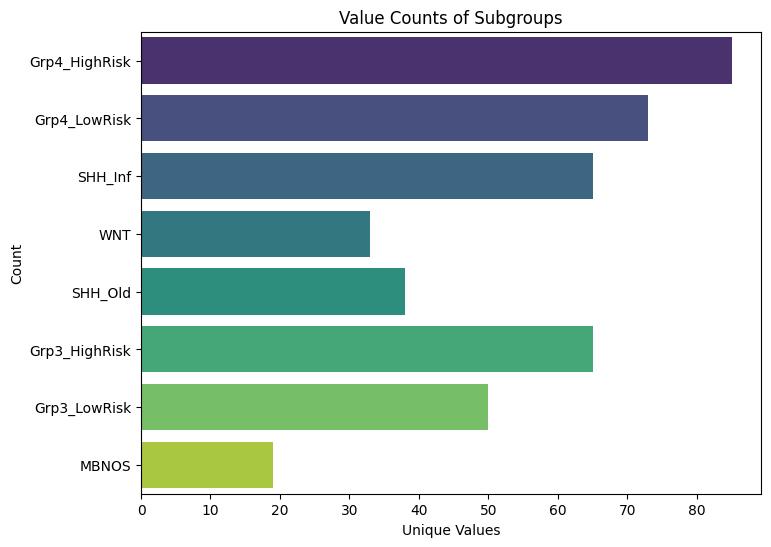

In [ ]:
# visualize the counts of subgroups samples
plt.figure(figsize=(8, 6))
sns.countplot(data=df_10K, y='Named_7_grp', hue='Named_7_grp', palette='viridis')
plt.title('Value Counts of Subgroups')
plt.xlabel('Unique Values')
plt.ylabel('Count')
plt.show()

In [ ]:
# value counts of subgroups
df_10K['Named_7_grp'].value_counts()

Named_7_grp
Grp4_HighRisk    85
Grp4_LowRisk     73
SHH_Inf          65
Grp3_HighRisk    65
Grp3_LowRisk     50
SHH_Old          38
WNT              33
MBNOS            19
Name: count, dtype: int64

In [ ]:
# shape of a df before removing samples
df_10K.shape

(428, 10001)

**Note:**
After examining the plot, it became evident that there are 19 samples labeled as MBNOS (not otherwise specified) subgroups. Given their small size and the potential to improve classification accuracy, these samples will be removed from the analysis.

In [ ]:
# filtering a df
df_10K = df_10K[df_10K['Named_7_grp'] != 'MBNOS']
df_10K['Named_7_grp'].value_counts()

Named_7_grp
Grp4_HighRisk    85
Grp4_LowRisk     73
SHH_Inf          65
Grp3_HighRisk    65
Grp3_LowRisk     50
SHH_Old          38
WNT              33
Name: count, dtype: int64

In [ ]:
# shape of a df after removing samples
df_10K.shape

(409, 10001)

In [ ]:
# splitting data and labels into 2 dfs
df_10K_labels = df_10K['Named_7_grp']
df_10K_labels = pd.DataFrame(df_10K_labels)

df_10K = df_10K.drop('Named_7_grp', axis=1)

In [ ]:
# shapes of data and labels dfs
df_10K_labels.shape, df_10K.shape

((409, 1), (409, 10000))

### 1.2.3 Label encoding

In [ ]:
# array of subgroup labels
labels = ['WNT', 'SHH_Inf', 'SHH_Old', 'Grp3_LowRisk', 'Grp3_HighRisk',
                  'Grp4_LowRisk', 'Grp4_HighRisk']

# mapping labels from 1-7
label_mappings = {label: i + 1 for i, label in enumerate(labels)}

print("Label Mappings:")
for label, value in label_mappings.items():
    print(f"{label}: {value}")

Label Mappings:
WNT: 1
SHH_Inf: 2
SHH_Old: 3
Grp3_LowRisk: 4
Grp3_HighRisk: 5
Grp4_LowRisk: 6
Grp4_HighRisk: 7


In [ ]:
# change the label column name into 'Subgroup'
df_10K_labels['Subgroup'] = df_10K_labels['Named_7_grp'].map(label_mappings)
df_10K_labels = df_10K_labels.drop('Named_7_grp', axis=1)
df_10K_labels

,Subgroup
NMB109,7
NMB110,6
NMB111,6
NMB113,2
NMB115,1
...,...
PNET350124,6
PNET350161,7
PNET350198,7
PNET350217,7


### 1.2.4 Examine range of values and descriptive statistics

In [ ]:
# check the minimum value
df_10K.min().min()

0.0

In [ ]:
# check the maximum value
df_10K.max().max()

0.99661800231413

In [ ]:
# check range of values
df_10K.describe()

,cg18409528,cg14399369,cg08879470,cg06539717,cg16400631,cg19119945,cg25324047,cg13539545,cg10512745,cg20820767,...,cg19074779,cg00981070,cg18539461,cg14023999,cg18229178,cg17033333,cg02391433,cg04528720,cg08648317,cg06732439
count,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000,...,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000
mean,0.520558,0.491898,0.464641,0.505268,0.483423,0.608646,0.475734,0.454447,0.432304,0.463023,...,0.386225,0.601146,0.384524,0.275671,0.370598,0.650193,0.462449,0.405019,0.543743,0.277939
std,0.417097,0.416042,0.413917,0.413606,0.410690,0.410146,0.406882,0.408145,0.405839,0.405793,...,0.293713,0.291386,0.291387,0.291985,0.292557,0.294997,0.291576,0.291501,0.293273,0.293354
min,0.000000,0.000000,0.007142,0.000000,0.015073,0.000000,0.018570,0.007956,0.000000,0.010094,...,0.000000,0.031214,0.000000,0.000000,0.000000,0.038215,0.043396,0.032736,0.029268,0.027923
25%,0.047977,0.036271,0.034232,0.037248,0.044866,0.048751,0.054371,0.035961,0.031401,0.034685,...,0.130067,0.359365,0.117257,0.045485,0.103717,0.428024,0.180046,0.144189,0.280059,0.052802
50%,0.686670,0.562100,0.434892,0.602478,0.441375,0.883625,0.375706,0.357712,0.297038,0.398088,...,0.303980,0.630191,0.305055,0.115669,0.257021,0.784773,0.411186,0.305853,0.573203,0.130654
75%,0.948069,0.928958,0.931769,0.944835,0.926449,0.955496,0.931560,0.934973,0.889167,0.924634,...,0.633302,0.875322,0.642670,0.501137,0.638660,0.899698,0.756450,0.705954,0.834078,0.436431
max,0.983325,0.979052,0.974648,0.988493,0.982581,0.984164,0.984345,0.988133,0.987939,0.984616,...,0.970229,0.985884,0.932566,0.949074,0.929960,0.976731,0.946056,0.949110,0.919891,0.943407


### 1.2.5 Non-negative Matrix Factorization (NMF)

In [ ]:
# transpose before applying NMF
df_10K_T = df_10K.T
df_10K_T

,NMB109,NMB110,NMB111,NMB113,NMB115,NMB116,NMB118,NMB119,NMB123,NMB125,...,PNET350015,PNET350049,PNET350080,PNET350091,PNET350120,PNET350124,PNET350161,PNET350198,PNET350217,PNET350241
cg18409528,0.908867,0.897980,0.954783,0.035246,0.028498,0.029503,0.965774,0.794259,0.027087,0.931392,...,0.884161,0.028203,0.073705,0.049053,0.203151,0.933619,0.159164,0.751099,0.616072,0.771797
cg14399369,0.908535,0.868319,0.937779,0.026458,0.029513,0.038511,0.960125,0.716980,0.034276,0.905180,...,0.306460,0.039200,0.047804,0.033816,0.154590,0.943713,0.916747,0.495938,0.138527,0.658963
cg08879470,0.940855,0.937518,0.966429,0.035980,0.022681,0.022304,0.960624,0.770870,0.139949,0.937766,...,0.734303,0.023098,0.067772,0.710308,0.162012,0.845062,0.956157,0.848702,0.804050,0.604314
cg06539717,0.921953,0.717546,0.969423,0.024075,0.016982,0.016804,0.977218,0.745092,0.017694,0.933227,...,0.236823,0.031633,0.052169,0.266942,0.162692,0.707782,0.889900,0.070881,0.135337,0.513954
cg16400631,0.024253,0.063243,0.042428,0.919919,0.954580,0.927506,0.152749,0.107198,0.917004,0.024417,...,0.376871,0.122528,0.800731,0.914442,0.390616,0.652269,0.243067,0.118010,0.361554,0.192173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cg17033333,0.899536,0.894106,0.883325,0.842464,0.181107,0.172889,0.806133,0.910345,0.888330,0.919557,...,0.448603,0.880281,0.618429,0.717756,0.344039,0.863949,0.901491,0.437390,0.415833,0.660809
cg02391433,0.610096,0.271122,0.183844,0.812694,0.064173,0.443585,0.105638,0.620700,0.838544,0.568465,...,0.572920,0.777818,0.128743,0.761874,0.684016,0.320813,0.428168,0.381338,0.700665,0.436470
cg04528720,0.184653,0.144189,0.150671,0.829037,0.762222,0.762491,0.108729,0.363477,0.719027,0.148930,...,0.170548,0.929437,0.694399,0.878512,0.688212,0.144706,0.178480,0.056816,0.343310,0.273538
cg08648317,0.707254,0.890426,0.891829,0.762321,0.080207,0.347853,0.406688,0.839912,0.555062,0.893044,...,0.767621,0.820746,0.155193,0.585193,0.438889,0.844778,0.888492,0.788755,0.608403,0.841431


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklea

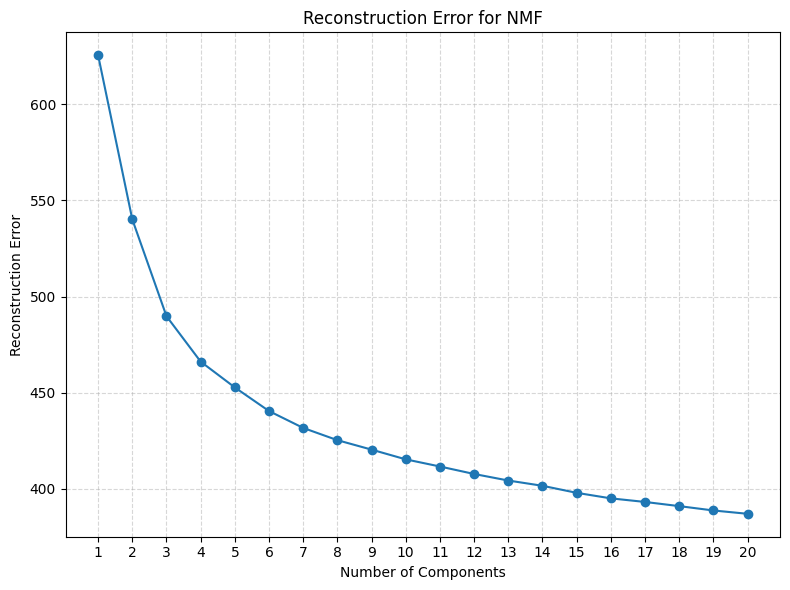

In [ ]:
# finding optimal number of components using reconstruction_error
# setting the maximum number of components to try
max_components = 20

# list to store reconstruction errors for each number of components
reconstruction_errors = []

# loop over different numbers of components
for num_components in range(1, max_components + 1):
    # initialize NMF model with random initialization
    nmf = NMF(n_components=num_components, init='random', random_state=42)

    # fit NMF model to the data
    nmf.fit(df_10K_T)

    # compute reconstruction error
    reconstruction_error = nmf.reconstruction_err_

    # append reconstruction error to the list
    reconstruction_errors.append(reconstruction_error)

# plotting reconstruction error against number of components
plt.figure(figsize=(8, 6))
plt.plot(range(1, max_components + 1), reconstruction_errors, marker='o', linestyle='-')
plt.title('Reconstruction Error for NMF')
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(np.arange(1, max_components + 1, 1))
plt.tight_layout()
plt.show()

**Note:**
Based on the elbow plot above, it's evident that there's no distinct elbow point where the curve sharply declines. However, starting from around 6 components, the curve begins to flatten out, indicating diminishing returns in terms of reducing the reconstruction error. Beyond 6 components, there's minimal change in the reconstruction error. Therefore, I've decided to consider 6 as the optimal number of components for this analysis.



In [ ]:
num_components = 6
nmf = NMF(n_components=num_components, init='random', random_state=42)
W = nmf.fit_transform(df_10K_T)
H = nmf.components_  # decomposed components matrix, representing features

W.shape, H.shape

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


((10000, 6), (6, 409))

In [ ]:
# transform into a new df
df_10K_nmf = pd.DataFrame(H, columns=df_10K_T.columns)
df_10K_nmf

,NMB109,NMB110,NMB111,NMB113,NMB115,NMB116,NMB118,NMB119,NMB123,NMB125,...,PNET350015,PNET350049,PNET350080,PNET350091,PNET350120,PNET350124,PNET350161,PNET350198,PNET350217,PNET350241
0,0.000000,0.288423,0.395235,0.000000,0.000000,0.047464,0.271350,0.073437,0.022009,0.046471,...,0.099881,0.151174,0.011784,0.000000,0.067006,0.310545,0.060900,0.104613,0.018778,0.083397
1,0.013993,0.040466,0.012295,0.217720,0.114922,0.015079,0.135918,0.021570,0.552396,0.000000,...,0.000000,0.020927,0.058601,0.247786,0.171884,0.253896,0.000000,0.000000,0.049402,0.170985
2,0.005140,0.000000,0.000000,0.016995,0.089499,0.129730,0.061493,0.117656,0.000000,0.000000,...,0.154671,0.416378,0.138915,0.095276,0.286517,0.123786,0.058826,0.107508,0.155935,0.232074
3,0.078258,0.053589,0.027666,1.049237,0.070074,0.166391,0.000000,0.315542,0.859924,0.119438,...,0.180067,0.618414,0.042090,0.806577,0.321183,0.038796,0.112547,0.167817,0.123671,0.067312
4,0.983622,0.625712,0.706544,0.000000,0.065327,0.062199,0.618285,0.779648,0.157654,0.947893,...,0.687701,0.206329,0.022344,0.071894,0.140631,0.616568,0.952404,0.602156,0.616347,0.630351
5,0.000000,0.013868,0.156725,0.070025,1.615554,1.482271,0.000000,0.102364,0.131715,0.000000,...,0.000000,0.290962,1.566672,0.233215,0.287787,0.125860,0.031911,0.000000,0.076854,0.000000


In [ ]:
# transpose a df
df_10K_nmf = df_10K_nmf.T
columns = ['V%i' % i for i in range(1, num_components + 1)]
df_10K_nmf.columns = columns
df_10K_nmf

,V1,V2,V3,V4,V5,V6
NMB109,0.000000,0.013993,0.005140,0.078258,0.983622,0.000000
NMB110,0.288423,0.040466,0.000000,0.053589,0.625712,0.013868
NMB111,0.395235,0.012295,0.000000,0.027666,0.706544,0.156725
NMB113,0.000000,0.217720,0.016995,1.049237,0.000000,0.070025
NMB115,0.000000,0.114922,0.089499,0.070074,0.065327,1.615554
...,...,...,...,...,...,...
PNET350124,0.310545,0.253896,0.123786,0.038796,0.616568,0.125860
PNET350161,0.060900,0.000000,0.058826,0.112547,0.952404,0.031911
PNET350198,0.104613,0.000000,0.107508,0.167817,0.602156,0.000000
PNET350217,0.018778,0.049402,0.155935,0.123671,0.616347,0.076854


### 1.2.6 Heatmap Visualisation

In [ ]:
# preprocess to visualize the components in a heatmap
combined_df = pd.concat([df_10K_nmf, df_10K_labels['Subgroup']], axis=1)
combined_df_sorted = combined_df.sort_values(by='Subgroup')
combined_df_sorted_hm = combined_df_sorted.drop('Subgroup', axis=1)
combined_df_sorted_hm

,V1,V2,V3,V4,V5,V6
NMB858,0.035335,0.000000,0.094961,0.038679,0.000359,1.599541
NMB382,0.006762,0.006111,0.015893,0.179968,0.030074,1.562874
NMB380,0.065338,0.000860,0.060684,0.104401,0.031338,1.467370
PNET30009,0.096724,0.000775,0.182237,0.190476,0.033577,1.333554
NMB264,0.050079,0.118163,0.169633,0.117790,0.000000,1.363225
...,...,...,...,...,...,...
NMB77,0.063928,0.000000,0.026175,0.074970,0.818161,0.000000
NMB419,0.107845,0.000000,0.000000,0.361770,0.783249,0.000000
NMB421,0.000000,0.058023,0.000000,0.007963,1.046698,0.000000
NMB393,0.004351,0.112287,0.000000,0.045445,1.086221,0.000000


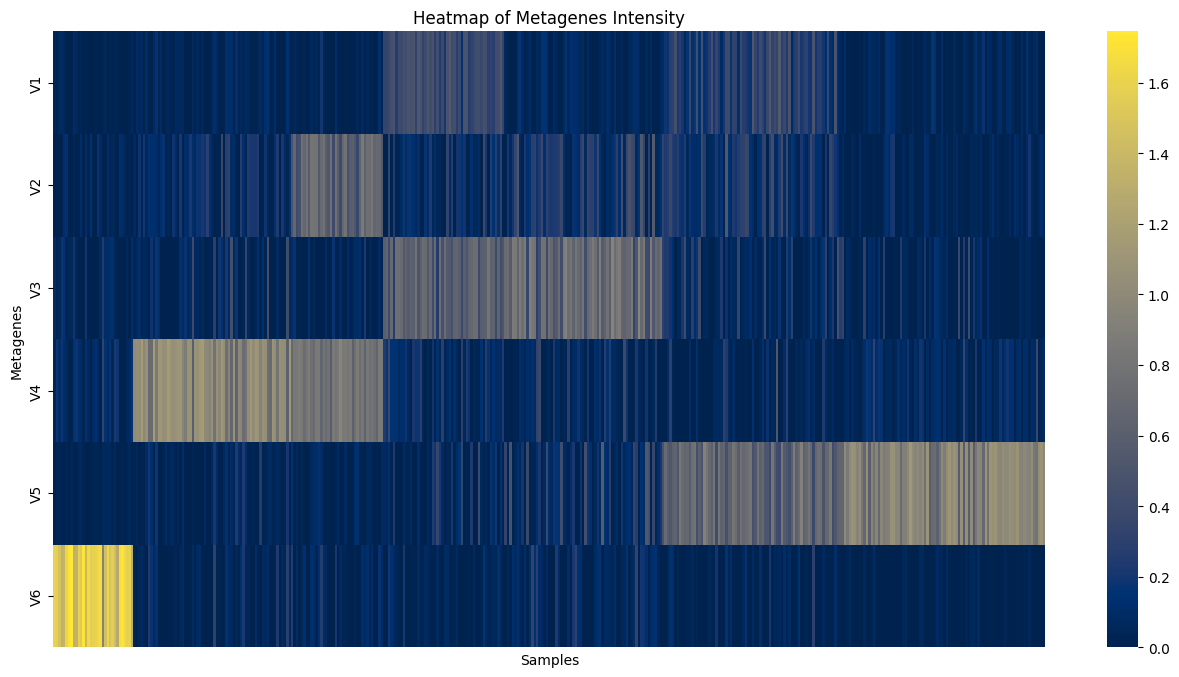

In [ ]:
# heatmap visualisation based on metagenes intensity
plt.figure(figsize=(16, 8))
sns.heatmap(combined_df_sorted_hm.T, cmap='cividis')
plt.title('Heatmap of Metagenes Intensity')
plt.xlabel('Samples')
plt.ylabel('Metagenes')
plt.xticks([])
plt.show()

**Note:**
As depicted in the heatmap above, distinct clusters emerge based on varying intensities of metagenes. The heatmap visualization highlights the patterns of expression across different metagenes, revealing clusters characterized by similar intensity profiles. This clustering based on metagene intensities provides valuable insights into underlying patterns of gene expression and helps identify groups of samples with similar biological characteristics or responses.



### 1.2.7 PCA Visualisations

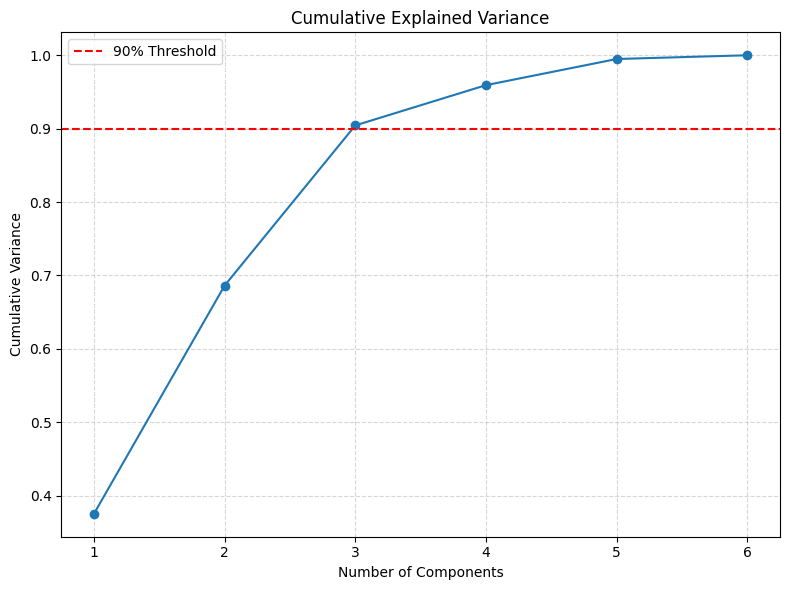

Optimal Number of Components: 3


In [ ]:
max_components = 6
cumulative_variance = []

# loop over different numbers of components for PCA
for num_components in range(1, max_components + 1):
    # initialize PCA model
    pca = PCA(n_components=num_components)

    # fit PCA model to the NMF-transformed data
    pca.fit(df_10K_nmf)

    # compute cumulative explained variance
    cumulative_variance.append(np.sum(pca.explained_variance_ratio_))

# plotting cumulative explained variance against number of components
plt.figure(figsize=(8, 6))
plt.plot(range(1, max_components + 1), cumulative_variance, marker='o', linestyle='-')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')
plt.axhline(y=0.90, color='r', linestyle='--', linewidth=1.5, label='90% Threshold')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# determine optimal number of components based on the 90% threshold
optimal_num_components = np.argmax(np.array(cumulative_variance) >= 0.90) + 1
print("Optimal Number of Components:", optimal_num_components)

In [ ]:
# apply pca and create a new df for visulaisation
num_components = 3
pca = PCA(n_components=num_components)
df_10K_pca = pca.fit_transform(df_10K_nmf)

columns = ['PC%i' % i for i in range(1, num_components + 1)]
df_10K_pca = pd.DataFrame(df_10K_pca, columns=columns)
df_10K_pca

,PC1,PC2,PC3
0,0.658859,-0.008151,-0.330944
1,0.421936,0.012803,-0.136973
2,0.452232,0.149662,-0.183511
3,-0.645593,-0.503058,-0.302066
4,-0.633782,1.323144,-0.338614
...,...,...,...
404,0.352532,0.087617,-0.054154
405,0.609517,0.004342,-0.289512
406,0.336480,-0.050037,-0.114903
407,0.328601,0.032055,-0.100714


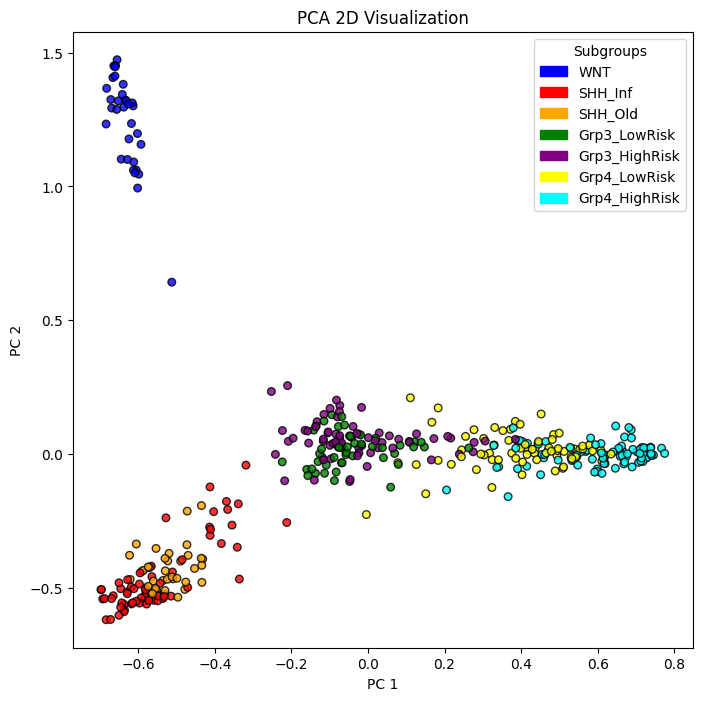

In [ ]:
# extract PC1 and PC2 from PCA df
pca1 = df_10K_pca['PC1']
pca2 = df_10K_pca['PC2']

# extract subgroup labels
subgroups = df_10K_labels['Subgroup']

# define color map for different subgroups
color_map = {1: 'blue', 2: 'red', 3: 'orange', 4: 'green',
             5: 'purple', 6: 'yellow', 7: 'cyan'}

# scatter plot of PCA 2D visualization
plt.figure(figsize=(8, 8))
plt.scatter(pca1, pca2, c=subgroups.map(color_map),
            edgecolor='k', alpha=0.8, s=30)

plt.title("PCA 2D Visualization")
plt.xlabel("PC 1")
plt.ylabel("PC 2")

# create legend patches for subgroups
legend_patches = [
    mpatches.Patch(color=color, label=labels[label-1]) for label, color in color_map.items()
]
plt.legend(handles=legend_patches, title='Subgroups')
plt.show()

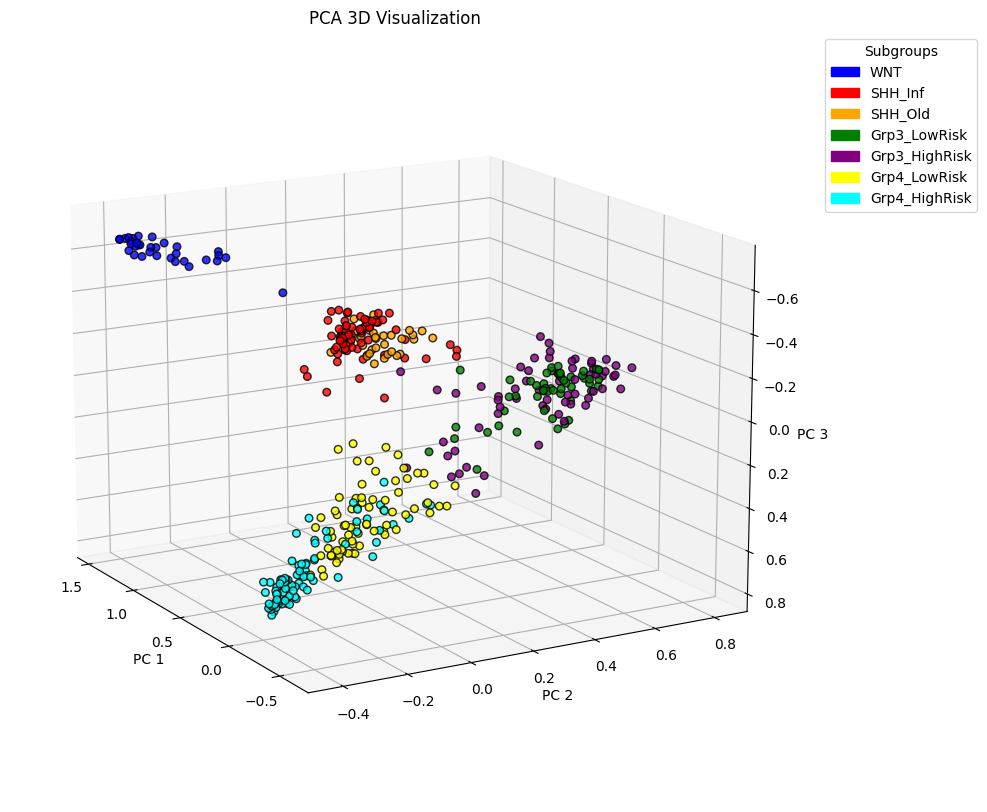

In [ ]:
# create a 3D scatter plot for PCA df
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

# define color map for different subgroups
color_map = {1: 'blue', 2: 'red', 3: 'orange', 4: 'green',
             5: 'purple', 6: 'yellow', 7: 'cyan'}

# extract PC1, PC2, and PC3 from PCA df
zdata = df_10K_pca['PC1']
xdata = df_10K_pca['PC2']
ydata = df_10K_pca['PC3']
subgroups = df_10K_labels['Subgroup']

# set plot title and axis labels
ax.set_title("PCA 3D Visualization")
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

# set view angle
ax.view_init(-165, 30)

# scatter plot with colored points based on subgroup
scatter = ax.scatter3D(xdata, ydata, zdata, c=subgroups.map(color_map),
                       edgecolor='k', alpha=0.8, s=30)

# create legend patches for subgroups
legend_patches = [
    mpatches.Patch(color=color, label=labels[label-1]) for label, color in color_map.items()
]

# display legend outside the plot area
plt.legend(handles=legend_patches, title='Subgroups', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

### 1.2.8 t-SNE Visualisations

In [ ]:
# apply t-SNE and create a new df for visulaisation
num_components = 2
tsne = TSNE(n_components=num_components, random_state=42)
df_10K_tsne = tsne.fit_transform(df_10K_nmf)

columns = ['TSNE%i' % i for i in range(1, num_components + 1)]
df_10K_tsne = pd.DataFrame(df_10K_tsne, columns=columns)
df_10K_tsne

,TSNE1,TSNE2
0,21.859852,-4.368708
1,12.490728,4.108685
2,12.018607,4.667797
3,-11.695866,-20.660603
4,-11.334569,38.916954
...,...,...
404,14.371892,6.082107
405,20.511415,-4.972323
406,12.206311,-2.449213
407,11.278249,-2.120605


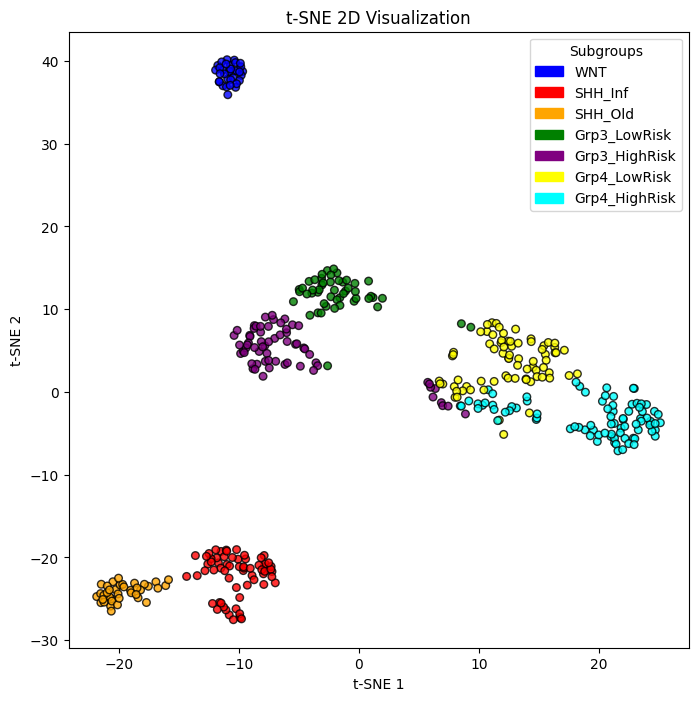

In [ ]:
# extract TSNE1 and TSNE2 from t-SNE df
tsne1 = df_10K_tsne['TSNE1']
tsne2 = df_10K_tsne['TSNE2']

# extract subgroup labels
subgroups = df_10K_labels['Subgroup']

# define color map for different subgroups
color_map = {1: 'blue', 2: 'red', 3: 'orange', 4: 'green',
             5: 'purple', 6: 'yellow', 7: 'cyan'}

# scatter plot of t-SNE 2D visualization
plt.figure(figsize=(8, 8))
plt.scatter(tsne1, tsne2, c=subgroups.map(color_map),
            edgecolor='k', alpha=0.8, s=30)

plt.title("t-SNE 2D Visualization")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

# create legend patches for subgroups
legend_patches = [
    mpatches.Patch(color=color, label=labels[label-1]) for label, color in color_map.items()
]
plt.legend(handles=legend_patches, title='Subgroups')
plt.show()

In [ ]:
# apply t-SNE and create a new df for visulaisation
num_components = 3
tsne = TSNE(n_components=num_components, random_state=42)
df_10K_tsne = tsne.fit_transform(df_10K_nmf)

columns = ['TSNE%i' % i for i in range(1, num_components + 1)]
df_10K_tsne = pd.DataFrame(df_10K_tsne, columns=columns)
df_10K_tsne

,TSNE1,TSNE2,TSNE3
0,5.387959,0.911196,-6.154022
1,5.175117,0.346738,0.664226
2,6.056705,0.251658,1.039625
3,-9.864738,-4.352771,-3.948492
4,-4.956224,13.078430,-1.772377
...,...,...,...
404,4.716512,2.556847,1.508252
405,5.202374,0.179740,-5.129010
406,2.894076,-0.391626,-1.264965
407,2.297406,0.174365,-1.226416


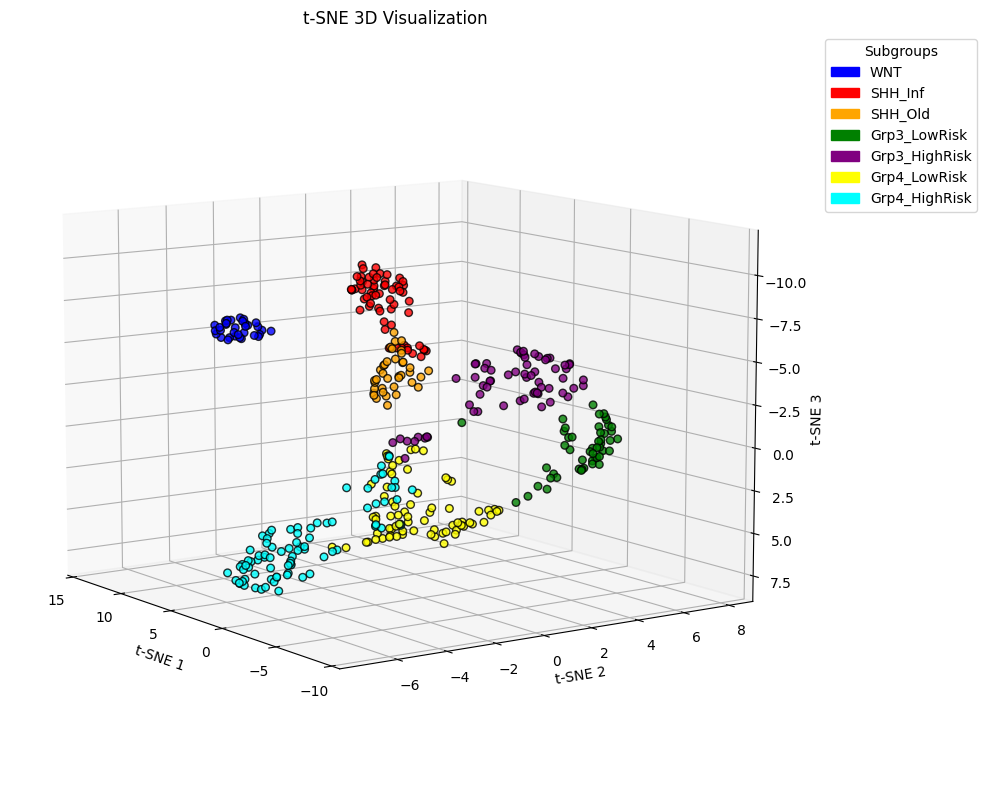

In [ ]:
# create a 3D scatter plot for t-SNE df
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection='3d')

# define color map for different subgroups
color_map = {1: 'blue', 2: 'red', 3: 'orange', 4: 'green',
             5: 'purple', 6: 'yellow', 7: 'cyan'}

# extract TSNE1, TSNE2, and TSNE3 from t-SNE df
zdata = df_10K_tsne['TSNE1']
xdata = df_10K_tsne['TSNE2']
ydata = df_10K_tsne['TSNE3']
subgroups = df_10K_labels['Subgroup']

# set plot title and axis labels
ax.set_title("t-SNE 3D Visualization")
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.set_zlabel('t-SNE 3')

# set view angle
ax.view_init(-170, 35)

# scatter plot with colored points based on subgroup
scatter = ax.scatter3D(xdata, ydata, zdata, c=subgroups.map(color_map),
                       edgecolor='k', alpha=0.8, s=30)

# create legend patches for subgroups
legend_patches = [
    mpatches.Patch(color=color, label=labels[label-1]) for label, color in color_map.items()
]

# display legend outside the plot area
plt.legend(handles=legend_patches, title='Subgroups', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

**Note:**
Although the separation isn't clear in PCA plots, t-SNE plots reveal distinct clusters separating into 7 subgroups in both 2D and 3D. t-SNE, or t-distributed stochastic neighbor embedding, is a nonlinear dimensionality reduction technique known for its effectiveness in preserving local structure and revealing meaningful clusters in high-dimensional data. Unlike PCA, which focuses on capturing global variance, t-SNE aims to preserve local relationships between data points. As a result, t-SNE often provides clearer visualizations of complex data structures and can be particularly useful for identifying distinct subgroups or clusters within the data.


### 1.2.9 Data normalisation

**Note:**
As a final step, I will apply MinMaxScaler to normalize the data to fall within the range of 0 to 1 for developing the classification model. This method is chosen for its robustness to outliers.

In [ ]:
df_10K_nmf

,V1,V2,V3,V4,V5,V6
NMB109,0.000000,0.013993,0.005140,0.078258,0.983622,0.000000
NMB110,0.288423,0.040466,0.000000,0.053589,0.625712,0.013868
NMB111,0.395235,0.012295,0.000000,0.027666,0.706544,0.156725
NMB113,0.000000,0.217720,0.016995,1.049237,0.000000,0.070025
NMB115,0.000000,0.114922,0.089499,0.070074,0.065327,1.615554
...,...,...,...,...,...,...
PNET350124,0.310545,0.253896,0.123786,0.038796,0.616568,0.125860
PNET350161,0.060900,0.000000,0.058826,0.112547,0.952404,0.031911
PNET350198,0.104613,0.000000,0.107508,0.167817,0.602156,0.000000
PNET350217,0.018778,0.049402,0.155935,0.123671,0.616347,0.076854


In [ ]:
# info of a df
df_10K_nmf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 409 entries, NMB109 to PNET350241
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      409 non-null    float64
 1   V2      409 non-null    float64
 2   V3      409 non-null    float64
 3   V4      409 non-null    float64
 4   V5      409 non-null    float64
 5   V6      409 non-null    float64
dtypes: float64(6)
memory usage: 38.5+ KB


In [ ]:
# check descriptive statistics
df_10K_nmf.describe()

,V1,V2,V3,V4,V5,V6
count,409.000000,409.000000,409.000000,409.000000,409.000000,409.000000
mean,0.127972,0.172019,0.238435,0.294763,0.355708,0.166708
std,0.150202,0.193789,0.284204,0.375926,0.377003,0.410974
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.004351,0.020283,0.000000,0.025878,0.024688,0.000000
50%,0.066677,0.115469,0.096072,0.107840,0.152865,0.022255
75%,0.191519,0.240865,0.425552,0.585740,0.691547,0.094172
max,0.550890,0.848694,0.962228,1.163268,1.122727,1.744842


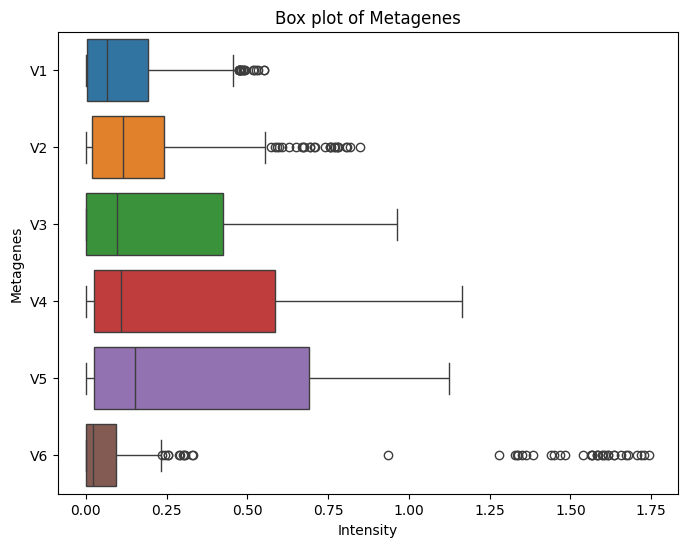

In [ ]:
# box plot to examine range of values for each component
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_10K_nmf, orient='h')
plt.title('Box plot of Metagenes')
plt.xlabel('Intensity')
plt.ylabel('Metagenes')
plt.show()

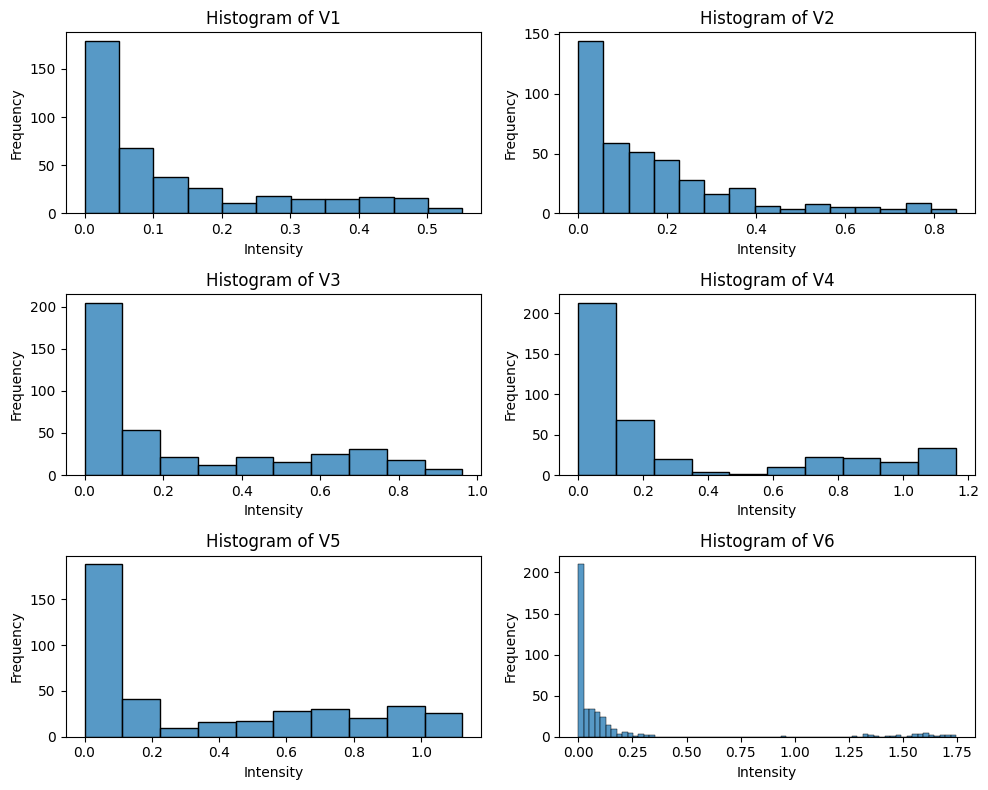

In [ ]:
# histogram to examine range of values for each component
fig, axes = plt.subplots(3, 2, figsize=(10, 8))
axes = axes.flatten()

for i, (column, ax) in enumerate(zip(df_10K_nmf.columns, axes)):
    sns.histplot(df_10K_nmf[column], ax=ax)
    ax.set_title(f'Histogram of {column}')
    ax.set_xlabel('Intensity')
    ax.set_ylabel('Frequency')

for ax in axes[len(df_10K_nmf.columns):]:
    ax.remove()

plt.tight_layout()
plt.show()

**Note:**
Despite the presence of extreme data in component 6, it's conceivable that these outliers may represent crucial biological phenomena. Therefore, outliers were retained in the dataset

In [ ]:
# apply normalisation
scaler = MinMaxScaler()
df_10K_nmf_scaled = scaler.fit_transform(df_10K_nmf)
df_10K_nmf_scaled = pd.DataFrame(df_10K_nmf_scaled, index=df_10K_nmf.index, columns=df_10K_nmf.columns)
df_10K_nmf_scaled

,V1,V2,V3,V4,V5,V6
NMB109,0.000000,0.016488,0.005342,0.067275,0.876101,0.000000
NMB110,0.523559,0.047680,0.000000,0.046068,0.557315,0.007948
NMB111,0.717448,0.014487,0.000000,0.023783,0.629310,0.089822
NMB113,0.000000,0.256535,0.017662,0.901974,0.000000,0.040133
NMB115,0.000000,0.135411,0.093012,0.060239,0.058186,0.925903
...,...,...,...,...,...,...
PNET350124,0.563715,0.299161,0.128645,0.033351,0.549170,0.072132
PNET350161,0.110549,0.000000,0.061135,0.096751,0.848295,0.018289
PNET350198,0.189898,0.000000,0.111728,0.144264,0.536334,0.000000
PNET350217,0.034088,0.058209,0.162056,0.106313,0.548973,0.044046


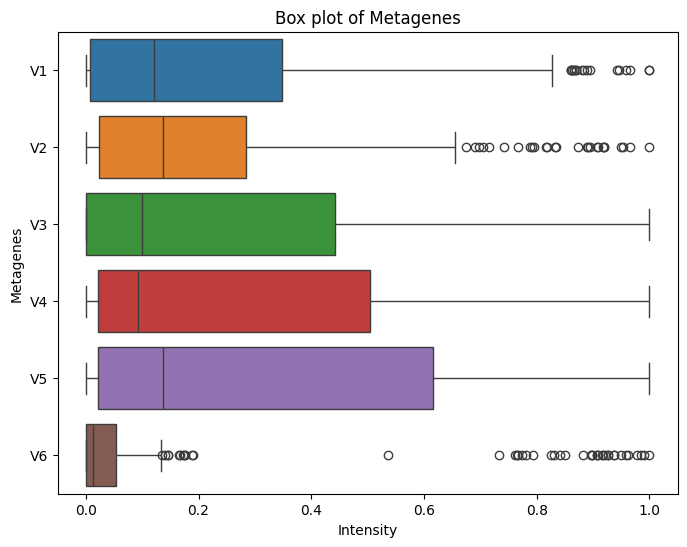

In [ ]:
# examine box plot after normalisation
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_10K_nmf_scaled, orient='h')
plt.title('Box plot of Metagenes')
plt.xlabel('Intensity')
plt.ylabel('Metagenes')
plt.show()

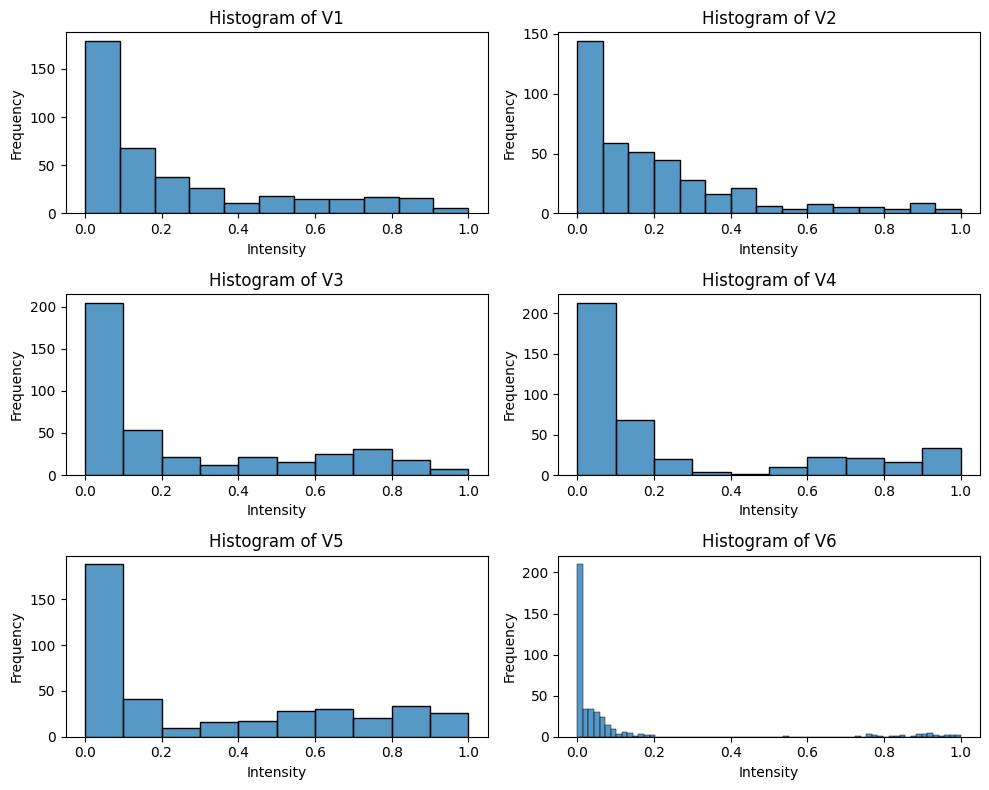

In [ ]:
# examine histogram after normalisation
fig, axes = plt.subplots(3, 2, figsize=(10, 8))
axes = axes.flatten()

for i, (column, ax) in enumerate(zip(df_10K_nmf_scaled.columns, axes)):
    sns.histplot(df_10K_nmf_scaled[column], ax=ax)
    ax.set_title(f'Histogram of {column}')
    ax.set_xlabel('Intensity')
    ax.set_ylabel('Frequency')

for ax in axes[len(df_10K_nmf.columns):]:
    ax.remove()

plt.tight_layout()
plt.show()

In [ ]:
# concatenate metagene components data and encoded subgroup labels
df_10K_processed = pd.concat([df_10K_nmf_scaled, df_10K_labels], axis=1)
df_10K_processed

,V1,V2,V3,V4,V5,V6,Subgroup
NMB109,0.000000,0.016488,0.005342,0.067275,0.876101,0.000000,7
NMB110,0.523559,0.047680,0.000000,0.046068,0.557315,0.007948,6
NMB111,0.717448,0.014487,0.000000,0.023783,0.629310,0.089822,6
NMB113,0.000000,0.256535,0.017662,0.901974,0.000000,0.040133,2
NMB115,0.000000,0.135411,0.093012,0.060239,0.058186,0.925903,1
...,...,...,...,...,...,...,...
PNET350124,0.563715,0.299161,0.128645,0.033351,0.549170,0.072132,6
PNET350161,0.110549,0.000000,0.061135,0.096751,0.848295,0.018289,7
PNET350198,0.189898,0.000000,0.111728,0.144264,0.536334,0.000000,7
PNET350217,0.034088,0.058209,0.162056,0.106313,0.548973,0.044046,7


In [ ]:
# info of a processed df
df_10K_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 409 entries, NMB109 to PNET350241
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   V1        409 non-null    float64
 1   V2        409 non-null    float64
 2   V3        409 non-null    float64
 3   V4        409 non-null    float64
 4   V5        409 non-null    float64
 5   V6        409 non-null    float64
 6   Subgroup  409 non-null    int64  
dtypes: float64(6), int64(1)
memory usage: 41.7+ KB


In [ ]:
# save into a csv file
df_10K_processed.to_csv(os.path.join(pth, '40419837_KaungHtet_Hein_ECS8055_B_ICW_180424.csv'), index=False)

## 2. Classification Model Development

After completing data preprocessing, the next phase was model development, which included the following tasks:

- **Splitting Data:** The dataset was divided into 80% for training and 20% for testing to ensure a proper evaluation of model performance.

- **Model Selection:** Four classifier models, namely Support Vector Machine (SVM), K-Nearest Neighbors (KNN), Random Forest (RF), and Gradient Boosting (GB), were tested using default parameters to determine their baseline performance.

- **Hyperparameter Tuning:** To enhance model performance, hyperparameters were optimized through grid search cross-validation (CV) with stratified K-fold validation, aiming to identify the most effective parameters for each model.

- **Methodologies Justification:** The rationale behind selecting each methodology was discussed as markdown.

### 2.1 Training and testing set prepration

In [ ]:
# directory of a preprocessed csv file
data_csv_file = '40419837_KaungHtet_Hein_ECS8055_B_ICW_180424.csv'
data_csv_path = os.path.join(pth, data_csv_file)

In [ ]:
# load the csv file into a df
df_10K_processed = pd.read_csv(data_csv_path)
df_10K_processed

,V1,V2,V3,V4,V5,V6,Subgroup
0,0.000000,0.016488,0.005342,0.067275,0.876101,0.000000,7
1,0.523559,0.047680,0.000000,0.046068,0.557315,0.007948,6
2,0.717448,0.014487,0.000000,0.023783,0.629310,0.089822,6
3,0.000000,0.256535,0.017662,0.901974,0.000000,0.040133,2
4,0.000000,0.135411,0.093012,0.060239,0.058186,0.925903,1
...,...,...,...,...,...,...,...
404,0.563715,0.299161,0.128645,0.033351,0.549170,0.072132,6
405,0.110549,0.000000,0.061135,0.096751,0.848295,0.018289,7
406,0.189898,0.000000,0.111728,0.144264,0.536334,0.000000,7
407,0.034088,0.058209,0.162056,0.106313,0.548973,0.044046,7


In [ ]:
# info a df
df_10K_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409 entries, 0 to 408
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   V1        409 non-null    float64
 1   V2        409 non-null    float64
 2   V3        409 non-null    float64
 3   V4        409 non-null    float64
 4   V5        409 non-null    float64
 5   V6        409 non-null    float64
 6   Subgroup  409 non-null    int64  
dtypes: float64(6), int64(1)
memory usage: 22.5 KB


In [ ]:
# split into samples, X and targets, y
X = df_10K_processed[['V1', 'V2', 'V3', 'V4', 'V5', 'V6']]
y = df_10K_processed['Subgroup']

print(X)
print(y)

           V1        V2        V3        V4        V5        V6
0    0.000000  0.016488  0.005342  0.067275  0.876101  0.000000
1    0.523559  0.047680  0.000000  0.046068  0.557315  0.007948
2    0.717448  0.014487  0.000000  0.023783  0.629310  0.089822
3    0.000000  0.256535  0.017662  0.901974  0.000000  0.040133
4    0.000000  0.135411  0.093012  0.060239  0.058186  0.925903
..        ...       ...       ...       ...       ...       ...
404  0.563715  0.299161  0.128645  0.033351  0.549170  0.072132
405  0.110549  0.000000  0.061135  0.096751  0.848295  0.018289
406  0.189898  0.000000  0.111728  0.144264  0.536334  0.000000
407  0.034088  0.058209  0.162056  0.106313  0.548973  0.044046
408  0.151386  0.201469  0.241184  0.057865  0.561446  0.000000

[409 rows x 6 columns]
0      7
1      6
2      6
3      2
4      1
      ..
404    6
405    7
406    7
407    7
408    6
Name: Subgroup, Length: 409, dtype: int64


In [ ]:
# shape of X and y
print(X.shape, y.shape)

(409, 6) (409,)


In [ ]:
# train test splitting, 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train)
print(X_test)
print(y_train)
print(y_test)

           V1        V2        V3        V4        V5        V6
108  0.102872  0.058717  0.000000  0.916807  0.054088  0.000000
377  0.024088  0.109517  0.000000  0.031659  1.000000  0.000000
247  0.000000  0.036884  0.000000  0.048345  0.935805  0.000000
175  0.000000  0.102156  0.031601  0.875695  0.019876  0.016966
3    0.000000  0.256535  0.017662  0.901974  0.000000  0.040133
..        ...       ...       ...       ...       ...       ...
71   0.090906  0.139229  0.176292  0.101258  0.000000  0.781288
106  0.000000  0.080627  0.655899  0.318003  0.061042  0.032729
270  0.268502  0.056964  0.055752  0.193270  0.722424  0.008851
348  0.000000  0.742252  0.238847  0.550526  0.004803  0.037144
102  0.667815  0.038969  0.000000  0.029805  0.619028  0.000000

[327 rows x 6 columns]
           V1        V2        V3        V4        V5        V6
172  0.005100  0.430996  0.156240  0.968609  0.000000  0.000000
137  0.000000  0.000000  0.032917  0.089767  0.884169  0.018505
126  0.000000  0

In [ ]:
# shapes of training sets and testing sets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(327, 6) (82, 6) (327,) (82,)


### 2.2 Model Selection

In [ ]:
# create a Support Vector Machine classifier with linear kernel
svm_classifier = SVC(kernel='linear', C=1.0, random_state=42)

# train the classifier on the training data
svm_classifier.fit(X_train, y_train)

# predict the labels for the test data
y_pred = svm_classifier.predict(X_test)

# compute the accuracy of the classifier
svm_accuracy = accuracy_score(y_test, y_pred)

# print the accuracy
print(f"SVM Accuracy: {svm_accuracy:.6f}")

SVM Accuracy: 0.987805


In [ ]:
# create a K-Nearest Neighbors classifier with 6 neighbors
knn_classifier = KNeighborsClassifier(n_neighbors=6)

# train the classifier on the training data
knn_classifier.fit(X_train, y_train)

# predict the labels for the test data
y_pred = knn_classifier.predict(X_test)

# compute the accuracy of the classifier
knn_accuracy = accuracy_score(y_test, y_pred)

# print the accuracy
print(f"KNN Accuracy: {knn_accuracy:.6f}")

KNN Accuracy: 0.975610


In [ ]:
# create a Random Forest classifier with 100 trees
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# train the classifier on the training data
rf_classifier.fit(X_train, y_train)

# predict the labels for the test data
y_pred = rf_classifier.predict(X_test)

# compute the accuracy of the classifier
rf_accuracy = accuracy_score(y_test, y_pred)

# print the accuracy
print(f"RF Accuracy: {rf_accuracy:.6f}")

RF Accuracy: 0.987805


In [ ]:
# create a Gradient Boosting classifier with 100 trees and learning rate of 0.1
gb_classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)

# train the classifier on the training data
gb_classifier.fit(X_train, y_train)

# predict the labels for the test data
y_pred = gb_classifier.predict(X_test)

# compute the accuracy of the classifier
gb_accuracy = accuracy_score(y_test, y_pred)

# print the accuracy
print(f"GB Accuracy: {gb_accuracy:.6f}")

GB Accuracy: 0.975610


In [ ]:
# accuracies of all ML models
print(f"SVM Accuracy: {svm_accuracy:.6f}")
print(f"KNN Accuracy: {knn_accuracy:.6f}")
print(f"RF  Accuracy: {rf_accuracy:.6f}")
print(f"GB  Accuracy: {gb_accuracy:.6f}")

SVM Accuracy: 0.987805
KNN Accuracy: 0.975610
RF  Accuracy: 0.987805
GB  Accuracy: 0.975610


**Note:**
Based on the above results, all the machine learning models, including Support Vector Machine (SVM), K-Nearest Neighbors (KNN), Random Forest (RF), and Gradient Boosting (GB), demonstrate high performance with no apparent need for further optimization. However, among the four models, SVM and RF exhibit superior accuracy, each achieving a score of 0.9878, while the other two models attain an accuracy of 0.9756.

SVM was selected due to its excellent generalization ability characteristics, including its ability to handle high-dimensional data well and its effectiveness in dealing with non-linear data distributions. Additionally, SVM is less prone to overfitting, making it suitable for datasets with a large number of features.

However, SVM also has some limitations. Firstly, it can be computationally expensive, especially when dealing with large datasets. Secondly, SVM's performance may deteriorate if the dataset is noisy or if the classes are not linearly separable.

Moving forward, this model will be optimized, and hyperparameters will be tuned to explore whether further improvements in performance can be achieved in the upcoming stages.

### 2.3 Model Optimisation

In [ ]:
# define the parameter grid for hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Kernel type
    'gamma': ['auto', 'scale', 0.1, 1, 10]  # Kernel coefficient for 'rbf', 'poly', and 'sigmoid'
}

# initialize the SVM classifier
svm_classifier = SVC(random_state=42)

# define the cross-validation strategy
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# perform grid search cross-validation
grid_search = GridSearchCV(svm_classifier, param_grid, cv=skf, scoring='accuracy')
grid_search.fit(X_train, y_train)

# retrieve best hyperparameters and best model
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_model = grid_search.best_estimator_

# evaluate the best model on the test set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the Best Model: {accuracy:.6f}")

Best Hyperparameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy of the Best Model: 0.987805


**Note:**
In the above section, hyperparameter tuning was conducted for the Support Vector Machine (SVM) classifier using grid search cross-validation. Grid search cross-validation was chosen for its ability to systematically search through a specified parameter grid and find the optimal combination of hyperparameters.

The parameter grid param_grid was defined to explore various hyperparameters, including the regularization parameter (C), kernel type (kernel), and kernel coefficient (gamma). By exploring different combinations of these hyperparameters, the goal was to identify the configuration that maximizes the model's accuracy.

To ensure robust evaluation and mitigate overfitting, a stratified k-fold cross-validation strategy (StratifiedKFold) with 5 splits was employed. This approach helps maintain the distribution of class labels in each fold, ensuring that the model's performance is reliably assessed across different subsets of the data.

Grid search cross-validation (GridSearchCV) was then performed using the defined parameter grid and cross-validation strategy. By evaluating each combination of hyperparameters on multiple folds of the training data, grid search helped identify the best-performing configuration.

After completing grid search cross-validation, the best hyperparameters and corresponding best model were retrieved from the results. The best model was then evaluated on the test set to assess its performance on unseen data. Additionally, the mean test score and parameter combinations were plotted as a heat map in the following section.











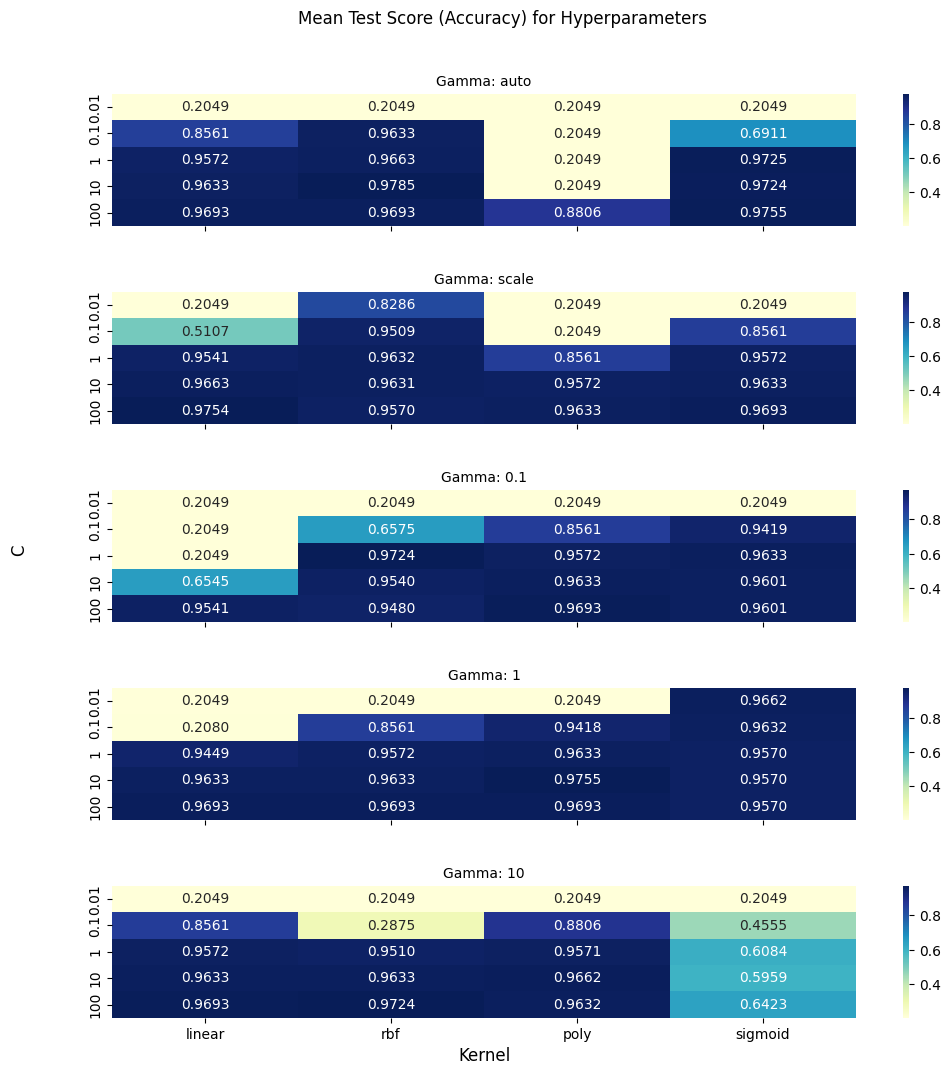

In [ ]:
# visualize Mean Test Score (Accuracy) for Hyperparameters
results = grid_search.cv_results_

# reshape mean test scores into a 3D array
mean_test_scores = np.array(results['mean_test_score']).reshape(len(param_grid['C']),
                                                                 len(param_grid['kernel']),
                                                                 len(param_grid['gamma']))

# create subplots for each gamma value
fig, axes = plt.subplots(nrows=len(param_grid['gamma']), ncols=1, figsize=(12, 12), sharex=True, sharey=True)

# iterate over gamma values and plot heatmaps
for i, gamma_val in enumerate(param_grid['gamma']):
    sns.heatmap(mean_test_scores[:, :, i], annot=True, fmt='.4f',
                xticklabels=param_grid['kernel'],
                yticklabels=param_grid['C'],
                cmap="YlGnBu", ax=axes[i])
    axes[i].set_title(f'Gamma: {gamma_val}', fontsize=10)
    axes[i].tick_params(axis='both', which='major', labelsize=10)

plt.xlabel('Kernel', fontsize=12)
fig.text(0.04, 0.5, 'C', va='center', rotation='vertical', fontsize=12)
plt.suptitle('Mean Test Score (Accuracy) for Hyperparameters', fontsize=12, x=0.45, y=0.95)
plt.subplots_adjust(hspace=0.5)
plt.show()

## 3. Model Training & Evaluation

During the final phase of the project, the model training and evaluation process was carried out in the following steps:

- **Model Training:** The SVM classifier - the chosen model - was trained using the best parameters obtained from hyperparameter tuning.

- **Model Evaluation** The trained model was evaluated using the test set. To comprehensively assess the model's performance, various performance metrics such as accuracy, classification report, and confusion matrix were generated.

- **Learning Curve and Generalizability:** A learning curve was constructed using stratified K-fold validation to visualize the model's learning process, understand the bias-variance trade-off, and assess its generalizability across unseen data.

- **Discussion:** Any issues that were identified, along with their sources, were discussed. Strategies were also proposed to mitigate these issues in future experiments.







### 3.1 Model Training

In [ ]:
# initialize SVM classifier with the best hyperparameters
svm_classifier = SVC(**best_params)

# train the SVM classifier on the training data
svm_classifier.fit(X_train, y_train)

# predict labels for the training data
y_pred_train = svm_classifier.predict(X_train)

# compute accuracy of the SVM classifier on the training set
svm_accuracy_train = accuracy_score(y_train, y_pred_train)
print(f"SVM Classifier Performance on Training Set:")
print(f"Accuracy: {svm_accuracy_train:.6f}")

# generate and print classification report for the training set
class_report_train = classification_report(y_train, y_pred_train, target_names=labels)
print("\nClassification Report:")
print(class_report_train)

SVM Classifier Performance on Training Set:
Accuracy: 0.993884

Classification Report:
               precision    recall  f1-score   support

          WNT       1.00      1.00      1.00        26
      SHH_Inf       1.00      1.00      1.00        54
      SHH_Old       1.00      1.00      1.00        29
 Grp3_LowRisk       1.00      1.00      1.00        40
Grp3_HighRisk       1.00      1.00      1.00        53
 Grp4_LowRisk       1.00      0.97      0.98        58
Grp4_HighRisk       0.97      1.00      0.99        67

     accuracy                           0.99       327
    macro avg       1.00      1.00      1.00       327
 weighted avg       0.99      0.99      0.99       327



In [ ]:
print(labels)

['WNT', 'SHH_Inf', 'SHH_Old', 'Grp3_LowRisk', 'Grp3_HighRisk', 'Grp4_LowRisk', 'Grp4_HighRisk']


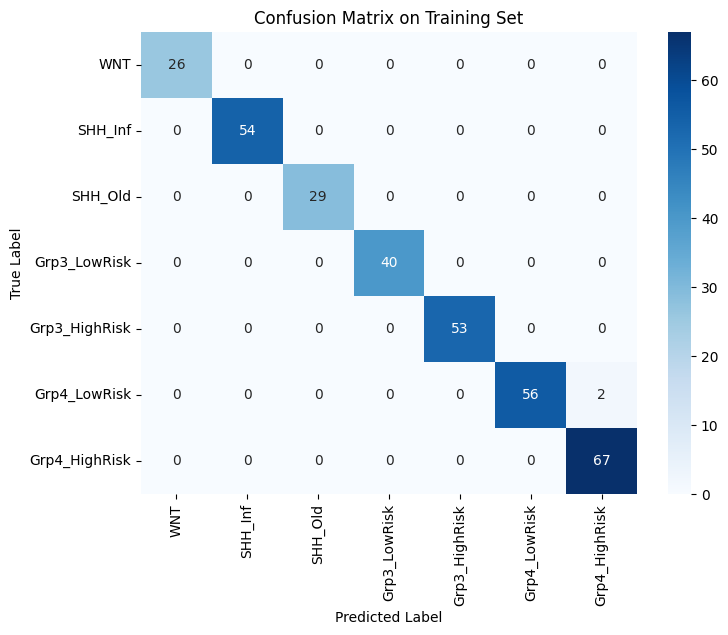

In [ ]:
# plot the confusion matrix using a heatmap
conf_matrix_train = confusion_matrix(y_train, y_pred_train)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_train, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix on Training Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### 3.2 Model Evaluation

In [ ]:
# predict labels for the test data using the trained SVM classifier
y_pred_test = svm_classifier.predict(X_test)

# compute accuracy of the SVM classifier on the test set
svm_accuracy_test = accuracy_score(y_test, y_pred_test)
print("SVM Classifier Performance on Test Set:")
print(f"Accuracy: {svm_accuracy_test:.6f}")

# generate and print classification report for the test set
class_report_test = classification_report(y_test, y_pred_test, target_names=labels)
print("\nClassification Report on Test Set:")
print(class_report_test)

SVM Classifier Performance on Test Set:
Accuracy: 0.987805

Classification Report on Test Set:
               precision    recall  f1-score   support

          WNT       1.00      1.00      1.00         7
      SHH_Inf       1.00      0.91      0.95        11
      SHH_Old       0.90      1.00      0.95         9
 Grp3_LowRisk       1.00      1.00      1.00        10
Grp3_HighRisk       1.00      1.00      1.00        12
 Grp4_LowRisk       1.00      1.00      1.00        15
Grp4_HighRisk       1.00      1.00      1.00        18

     accuracy                           0.99        82
    macro avg       0.99      0.99      0.99        82
 weighted avg       0.99      0.99      0.99        82



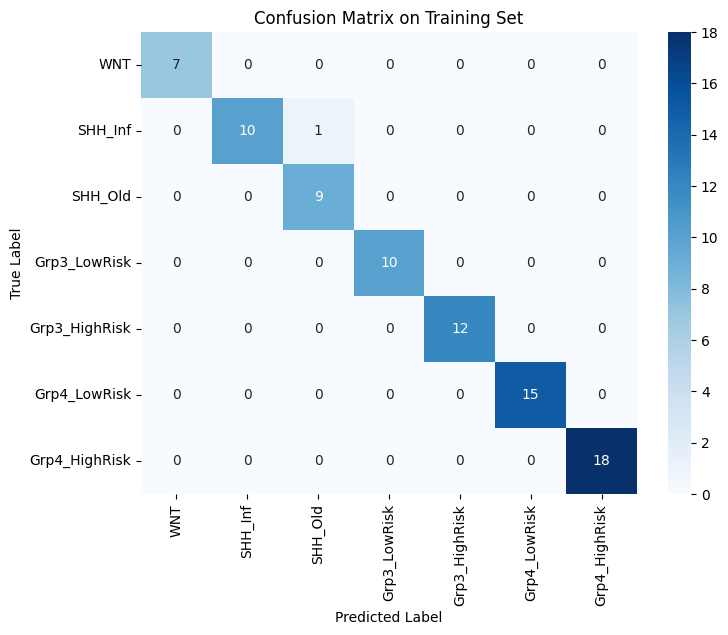

In [ ]:
# plot the confusion matrix using a heatmap
conf_matrix_test = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix on Training Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

**Note:**
The model showed an accuracy of 0.9938 on the training set and 0.9878 on the testing set, as demonstrated above. However, despite being trained with the best parameters, the model's performance did not significantly improve. Additionally, after examining the confusion matrix, it was observed that there were 2 incorrect predictions between (Grp4_LowRisk) and (Grp4_HighRisk) on the training set, and 1 incorrect prediction between (SHH_Inf) and (SHH_Old).

The reason for these misclassifications could be due to insufficient data and class imbalance. Only 327 samples were used to train the model, and the misclassifications occur within the same branch of subgroups. Furthermore, the dataset's features may not fully capture the underlying patterns or nuances between certain classes, making it difficult for the model to differentiate them accurately.

To address these issues and enhance the model's performance while reducing misclassifications, strategies such as data augmentation, feature engineering, or collecting more diverse data can be employed.







### 3.3 Learning curve and generalisability

In [ ]:
# define the number of folds and training sizes for learning curve
n_folds = 20
train_sizes = np.linspace(0.1, 1.0, 10)

# initialize stratified k-fold cross-validation
skf = StratifiedKFold(n_splits=n_folds)

# compute learning curve
train_sizes_abs, train_scores, test_scores = learning_curve(
    estimator=svm_classifier,
    X=X,
    y=y,
    train_sizes=train_sizes,
    cv=skf,
    scoring='accuracy',
    n_jobs=-1
)

# compute mean and standard deviation of training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

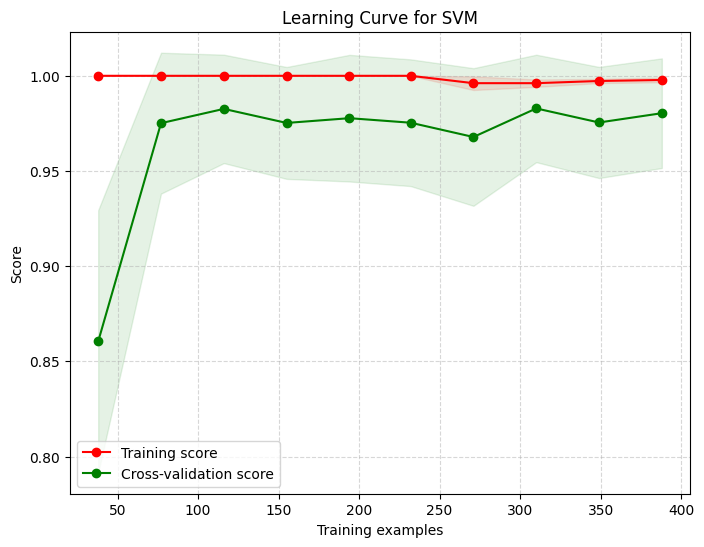

In [ ]:
# plot learning curve
plt.figure(figsize=(8, 6))
plt.fill_between(train_sizes_abs, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes_abs, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes_abs, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes_abs, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.title("Learning Curve for SVM")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [ ]:
# overall performance
overall_train_mean_accuracy = round(np.mean(train_scores_mean), 4)
overall_test_mean_accuracy = round(np.mean(test_scores_mean), 4)

print("Overall Mean Training Accuracy:", overall_train_mean_accuracy)
print("Overall Mean Validation Accuracy:", overall_test_mean_accuracy)

Overall Mean Training Accuracy: 0.9987
Overall Mean Validation Accuracy: 0.9653


**Note:**
The plot above indicates that the model is performing well overall. At the beginning of the training process, there's a noticeable difference between the training and cross-validation curves, which suggests some overfitting. However, as the training progresses, the two curves converge, indicating a good balance between bias and variance.

Although there's a slight decrease in the validation accuracy as compared to the training accuracy, the model still maintains an overall accuracy of 96.5%, which is a promising sign.

In summary, the model has a strong ability to generalize, with an accuracy of more than 96.5% on cross-validation. Despite its high performance, it's essential to remain cautious about potential misclassifications, given the significance of the task.

### Conclusion

In this individual coursework, a classification model was developed to classify childhood medulloblastoma cases into seven subgroups with higher precision. The high-dimensional epigenetic data from the Illumina 450K methylation microarray was preprocessed and reduced into the top 10K variably methylated dataset. This data was further preprocessed to be ready for classification model development. Four proposed classifier models were evaluated, and the SVM classifier was selected for its excellent generalization ability characteristics, including its ability to handle high-dimensional data well and its effectiveness in dealing with non-linear data distributions. The chosen model was then trained and tuned to get the optimal set of hyper-parameters. The trained model was evaluated on a test dataset, which was 20% of the original processed dataset. Performance metrics such as accuracy, classification report, and confusion matrices were produced for both the training and testing sets and then compared. A learning curve was also produced to check the learning of the model and its generalizability across unseen data. Overall, the model achieved 99.3% accuracy on the training set, 98.7% on the testing set, and 96.5% as a mean validation accuracy. Although some mispredictions occurred, the model was capable of achieving high prediction and maintaining this performance over the unseen data. The identified issues, along with their sources and strategies to mitigate them, were also discussed in the report. In conclusion, this project successfully achieved high accuracy prediction for classifying seven subgroups of childhood medulloblastoma cases.